<a href="https://colab.research.google.com/github/arpan1975/signals-4-swing-trading/blob/main/Swing%20Trading%20Strategy%20using%20EMA_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
# Swing Testing Strategy

---

> Strategy Overview:
> This strategy aims to capture teh short and mid-term trends of the stock.

> Strategy Principles:
> Core princplies are as follows:

> Calculate two moving averages, fast-EMA (5d) and slow-EMA (20d)
> Make an entry when closing price crosses above the fast-EMA
> Make an exit when closing price crosse below the fast-EMA and slow-EMA is above fast-EMA, holding duration is erual to or greater than 25 days
> Make an exit when price goes below stop-loss (2% of buy price)

```



In [1]:
""" Include all required libraries
"""
import yfinance as yf
import pandas as pd
import numpy as np
import math
from termcolor import colored as cl
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
""" Function to add calculate the return for each stock for the given period
"""
def calculate_return(df, ticker, start, end, investment, stop_loss_pct, duration):

    implement_strategy(df, ticker, start, end, investment, stop_loss_pct, duration)
    generate_plot(df, ticker)

In [3]:
""" Function to log all buy and sell transactions
"""
def implement_strategy(df, ticker, start, end, investment, stop_loss_pct, duration):

## pending: add the logic of training stop loss
    in_position = False
    equity = investment
    stop_loss = 0
    target_book = 0
    buy_price = 0
    start_d = 0

    print(cl(f'\nOrder book for {ticker} between {start} and {end}', attrs = ['bold']))
    print(f'------------------------------------------------')

    for i in range(3, len(df)):

        if df['Close'][i] > df['EMA_S'][i] and df['CL_EMA(S)'][i] < 1 and in_position == False:
            buy_price = df.Close[i]
            no_of_shares = math.floor(equity/df.Close[i])
            equity -= (no_of_shares * df.Close[i])
            in_position = True
            df['Buy'][i] = 1
            stop_loss = df.Close[i] * (1 - stop_loss_pct)
            target_book = df.Close[i] * (1 + 2 * stop_loss_pct)
            start_d = i
            print(cl('BUY: ', color = 'green', attrs = ['bold']), f'{no_of_shares} Shares are bought at ₹{df.Close[i]} on {df.index[i]}')
        elif df['Close'][i] < df['EMA_S'][i] and df['Close'][i] < df['EMA_M'][i] and df['EMA_M'][i] > df['EMA_S'][i] and df['CL_EMA(S)'][i] > 1 \
        and (i - start_d) >= duration and in_position == True:
            print(i, start_d)
            equity += (no_of_shares * df.Close[i])
            in_position = False
            df['Sell'][i] = 1
            stop_loss = 0
            target_book = 0
            start_d = 0
            print(cl('SELL: ', color = 'red', attrs = ['bold']), f'{no_of_shares} Shares are sold at ₹{df.Close[i]} on {df.index[i]}')
        elif df['Low'][i] <= stop_loss and in_position == True:
            equity += (no_of_shares * df.Close[i])
            in_position = False
            df['Sell'][i] = 1
            stop_loss = 0
            target_book = 0
            start_d = 0
            print(cl('SELL: ', color = 'red', attrs = ['bold']), f'{no_of_shares} Shares are sold at ₹{df.Close[i]} on {df.index[i]}')
        #elif df['Close'][i] * (1 - stop_loss_pct) > stop_loss and df['Close'][i] > buy_price and in_position == True:
        #    stop_loss = df['Close'][i] * (1 - stop_loss_pct)

    if in_position == True:
        equity += (no_of_shares * df.Close[i])
        print(cl(f'\nClosing position at {df.Close[i]} on {df.index[i]}', attrs = ['bold']))
        in_position = False

    earning = round(equity - investment, 2)
    roi = round(earning / investment * 100, 2)

    print('')
    print(cl(f'EARNING: ₹{earning} ; ROI: {roi}%', attrs = ['bold']))

    equity_1 = investment
    equity_1 = (math.floor(equity_1/df.Open[0]) * df.Close[i])
    earning_1 = round(equity_1 - investment, 2)
    roi_1 = round(earning_1 / investment * 100, 2)

    return_data.append([ticker, earning, roi, earning_1, roi_1])

    print(cl(f'Return with Buy-Hold strategy: EARNING: ₹{earning_1} ; ROI: {roi_1}%\n', attrs = ['bold']))
    #print(df.index[0], df.index[len(df) - 1])


In [4]:
""" Function to extract ticker list from Wikipedia source
"""
def get_ticker_list(url):

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    '''   @ Use this for Nifty50 stocks     '''
    table = soup.find('table', attrs={'class': 'wikitable sortable'})
    '''   @ Use this for Nifty500 stocks    '''
    #table = soup.find('table', attrs={'class': 'wikitable sortable mw-collapsible'})
    table_rows = table.find_all('tr')
    data = []
    for row in table.find_all('tr'):
        row_data = []
        for cell in row.find_all('th'):
            row_data.append(cell.text.replace('\n', ''))
        for cell in row.find_all('td'):
            row_data.append(cell.text.replace('\n', ''))
        data.append(row_data)
    header = data[0]
    tickers = pd.DataFrame(data[1:], columns=header)['Symbol'].tolist()
    for idx, item in enumerate(tickers):
        item = tickers[idx] + '.NS'
        tickers[idx] = item
    return tickers

In [5]:
""" Function to extract historical price using Yahoo Finance
"""
def extract_hist_price(ticker, period):

    df = yf.download(ticker, period=period)
    return df

In [6]:
""" Function to add EMA Indicators to the dataframe
"""
def add_ema_indicators(df, s, m, l):

    EMA_S_INTERVAL = s
    EMA_M_INTERVAL = m
    EMA_L_INTERVAL = l
    df['EMA_S'] = df['Close'].ewm(span=s, adjust=False).mean()
    df['EMA_M'] = df['Close'].ewm(span=m, adjust=False).mean()
    df['EMA_L'] = df['Close'].ewm(span=l, adjust=False).mean()
    df['CL_EMA(S)'] = df['Close']/df['EMA_S']
    df['CL_EMA(S)'] = df['CL_EMA(S)'].shift(1)
    df['CL_EMA(M)'] = df['Close']/df['EMA_M']
    df['CL_EMA(M)'] = df['CL_EMA(M)'].shift(1)
    df['EMA(SM)']  = df['EMA_S']/df['EMA_M']
    df['EMA(SM)'] = df['EMA(SM)'].shift(1)
    df['Buy'] = 0
    df['Sell'] = 0
    return df

In [7]:
def generate_plot(df, ticker):

    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['Close'], label='Close', color='blue', lw='0.5')
    plt.plot(df.index, df['EMA_S'], label='EMA_S', color='green', lw='0.75')
    plt.plot(df.index, df['EMA_M'], label='EMA_M', color='orange', lw='0.75')

    df['Buy_Signal'] = np.where(df['Buy'] == 1, True, False)
    df['Sell_Signal'] = np.where(df['Sell'] == 1, True, False)
    # Adding buy signals
    buy_signals = df.index[df['Buy_Signal']]
    plt.scatter(buy_signals, df['Close'][df['Buy_Signal']], marker='^', color='green', label='Buy Signal', s=100)

    # Adding sell signals
    sell_signals = df.index[df['Sell_Signal']]
    plt.scatter(sell_signals, df['Close'][df['Sell_Signal']], marker='v', color='red', label='Sell Signal', s=100)

    # Adding legend and labels
    plt.title(f'{ticker} : Price with Buy and Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

[*********************100%***********************]  1 of 1 completed



Order book for ADANIENT.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  480 Shares are bought at ₹208.0 on 2020-01-09 00:00:00
SELL:  480 Shares are sold at ₹199.6999969482422 on 2020-03-09 00:00:00
BUY:  725 Shares are bought at ₹132.3000030517578 on 2020-03-25 00:00:00
SELL:  725 Shares are sold at ₹128.0 on 2020-03-27 00:00:00
BUY:  675 Shares are bought at ₹137.60000610351562 on 2020-03-31 00:00:00
SELL:  675 Shares are sold at ₹133.9499969482422 on 2020-04-01 00:00:00
BUY:  654 Shares are bought at ₹138.14999389648438 on 2020-04-07 00:00:00
SELL:  654 Shares are sold at ₹138.10000610351562 on 2020-04-08 00:00:00
BUY:  643 Shares are bought at ₹140.5 on 2020-04-23 00:00:00
SELL:  643 Shares are sold at ₹134.64999389648438 on 2020-04-24 00:00:00
BUY:  621 Shares are bought at ₹139.3000030517578 on 2020-04-28 00:00:00
SELL:  621 Shares are sold at ₹139.5 on 2020-04-29 00:00:00
BUY:  643 Shares are bought at ₹134.89999389648438 on 2020-05-0

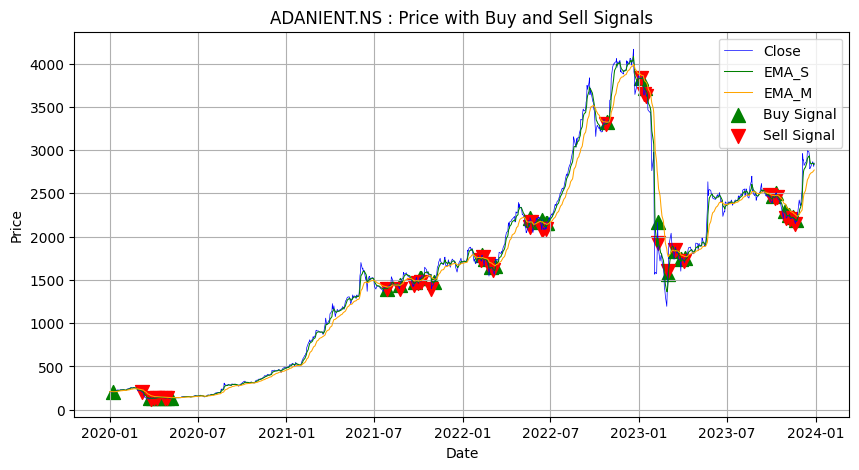

[*********************100%***********************]  1 of 1 completed



Order book for ADANIPORTS.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  259 Shares are bought at ₹385.8500061035156 on 2020-01-23 00:00:00
SELL:  259 Shares are sold at ₹372.95001220703125 on 2020-01-28 00:00:00
BUY:  252 Shares are bought at ₹383.3500061035156 on 2020-01-29 00:00:00
SELL:  252 Shares are sold at ₹369.3999938964844 on 2020-01-31 00:00:00
BUY:  248 Shares are bought at ₹374.20001220703125 on 2020-02-11 00:00:00
SELL:  248 Shares are sold at ₹366.8500061035156 on 2020-02-14 00:00:00
BUY:  245 Shares are bought at ₹371.29998779296875 on 2020-02-19 00:00:00
SELL:  245 Shares are sold at ₹362.25 on 2020-02-24 00:00:00
BUY:  255 Shares are bought at ₹349.1499938964844 on 2020-03-05 00:00:00
SELL:  255 Shares are sold at ₹341.3999938964844 on 2020-03-06 00:00:00
BUY:  340 Shares are bought at ₹255.60000610351562 on 2020-03-25 00:00:00
SELL:  340 Shares are sold at ₹248.1999969482422 on 2020-03-26 00:00:00
BUY:  341 Shares are bou

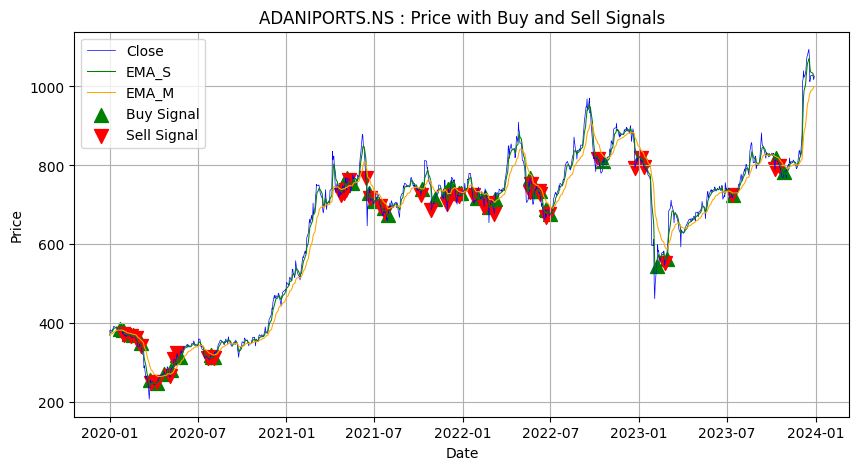

[*********************100%***********************]  1 of 1 completed



Order book for APOLLOHOSP.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  58 Shares are bought at ₹1695.8499755859375 on 2020-02-03 00:00:00
SELL:  58 Shares are sold at ₹1671.050048828125 on 2020-02-04 00:00:00
BUY:  59 Shares are bought at ₹1663.1500244140625 on 2020-02-07 00:00:00
SELL:  59 Shares are sold at ₹1640.9000244140625 on 2020-03-09 00:00:00
BUY:  71 Shares are bought at ₹1362.949951171875 on 2020-03-20 00:00:00
SELL:  71 Shares are sold at ₹1158.6500244140625 on 2020-03-23 00:00:00
BUY:  69 Shares are bought at ₹1189.550048828125 on 2020-04-03 00:00:00
91 64
SELL:  69 Shares are sold at ₹1266.050048828125 on 2020-05-18 00:00:00
BUY:  66 Shares are bought at ₹1321.75 on 2020-05-26 00:00:00
206 96
SELL:  66 Shares are sold at ₹2079.300048828125 on 2020-10-28 00:00:00
BUY:  65 Shares are bought at ₹2119.449951171875 on 2020-10-30 00:00:00
SELL:  65 Shares are sold at ₹2069.300048828125 on 2020-11-02 00:00:00
BUY:  63 Shares are bo

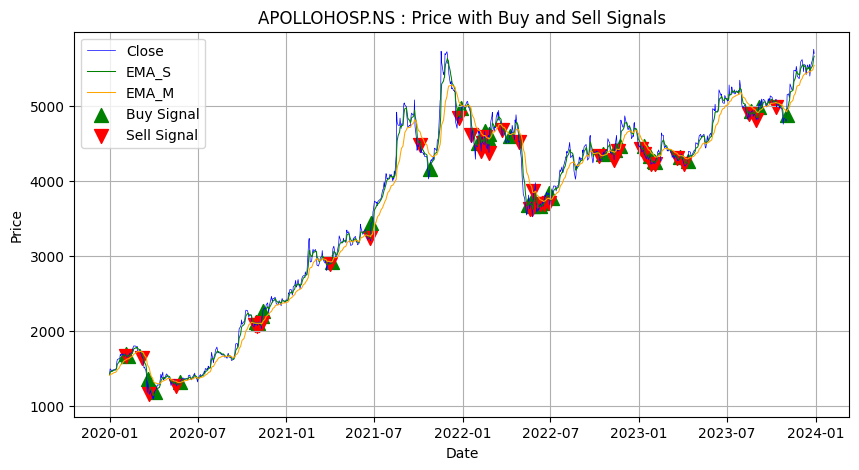

[*********************100%***********************]  1 of 1 completed



Order book for ASIANPAINT.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  56 Shares are bought at ₹1772.550048828125 on 2020-01-09 00:00:00
41 6
SELL:  56 Shares are sold at ₹1797.949951171875 on 2020-02-28 00:00:00
BUY:  54 Shares are bought at ₹1847.949951171875 on 2020-03-04 00:00:00
SELL:  54 Shares are sold at ₹1797.699951171875 on 2020-03-13 00:00:00
BUY:  56 Shares are bought at ₹1742.949951171875 on 2020-03-20 00:00:00
SELL:  56 Shares are sold at ₹1498.449951171875 on 2020-03-23 00:00:00
BUY:  52 Shares are bought at ₹1616.949951171875 on 2020-03-26 00:00:00
SELL:  52 Shares are sold at ₹1604.1500244140625 on 2020-03-27 00:00:00
BUY:  50 Shares are bought at ₹1666.5 on 2020-03-31 00:00:00
SELL:  50 Shares are sold at ₹1603.199951171875 on 2020-04-01 00:00:00
BUY:  49 Shares are bought at ₹1623.800048828125 on 2020-04-07 00:00:00
SELL:  49 Shares are sold at ₹1619.1500244140625 on 2020-05-05 00:00:00
BUY:  51 Shares are bought at ₹15

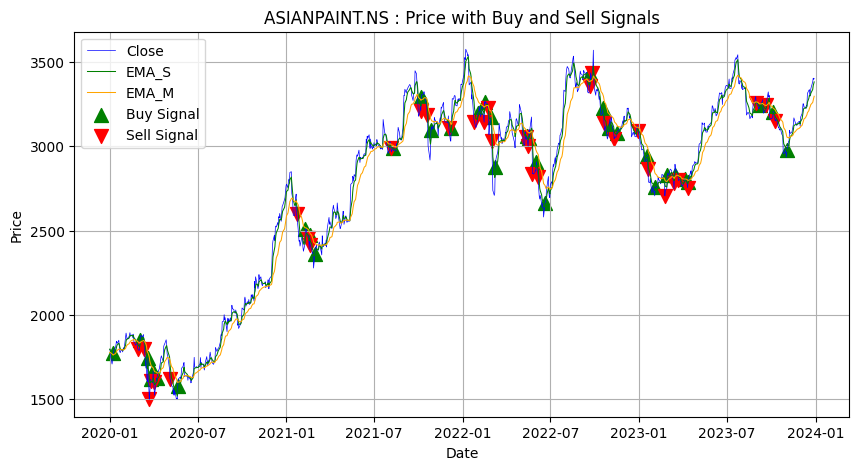

[*********************100%***********************]  1 of 1 completed



Order book for AXISBANK.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  134 Shares are bought at ₹742.8499755859375 on 2020-01-09 00:00:00
SELL:  134 Shares are sold at ₹727.2000122070312 on 2020-01-20 00:00:00
BUY:  132 Shares are bought at ₹737.4000244140625 on 2020-01-24 00:00:00
SELL:  132 Shares are sold at ₹708.9500122070312 on 2020-02-03 00:00:00
BUY:  130 Shares are bought at ₹724.0499877929688 on 2020-02-05 00:00:00
SELL:  130 Shares are sold at ₹697.2999877929688 on 2020-02-28 00:00:00
BUY:  252 Shares are bought at ₹359.75 on 2020-03-27 00:00:00
SELL:  252 Shares are sold at ₹368.1499938964844 on 2020-03-30 00:00:00
BUY:  238 Shares are bought at ₹388.8500061035156 on 2020-04-07 00:00:00
SELL:  238 Shares are sold at ₹391.3500061035156 on 2020-04-08 00:00:00
BUY:  218 Shares are bought at ₹427.29998779296875 on 2020-04-27 00:00:00
SELL:  218 Shares are sold at ₹402.79998779296875 on 2020-05-04 00:00:00
BUY:  212 Shares are bought 

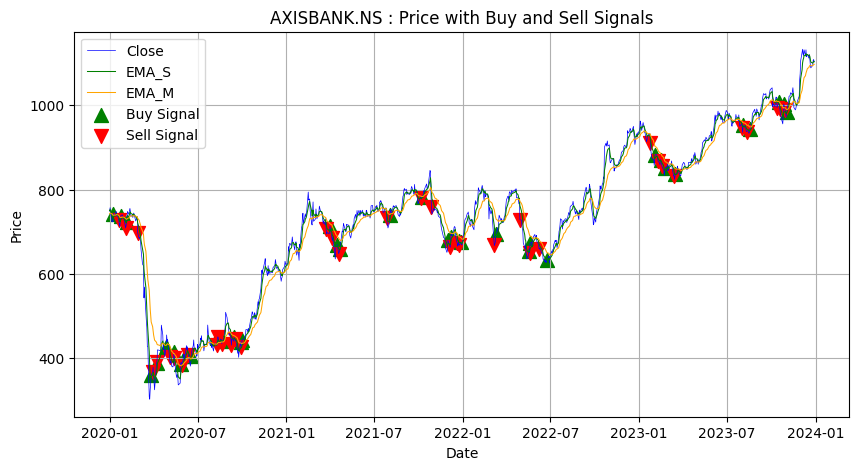

[*********************100%***********************]  1 of 1 completed



Order book for BAJAJ-AUTO.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  32 Shares are bought at ₹3085.699951171875 on 2020-01-09 00:00:00
33 6
SELL:  32 Shares are sold at ₹3075.60009765625 on 2020-02-17 00:00:00
BUY:  47 Shares are bought at ₹2106.85009765625 on 2020-03-26 00:00:00
SELL:  47 Shares are sold at ₹2053.449951171875 on 2020-03-27 00:00:00
BUY:  47 Shares are bought at ₹2051.10009765625 on 2020-04-01 00:00:00
SELL:  47 Shares are sold at ₹2033.75 on 2020-04-03 00:00:00
BUY:  42 Shares are bought at ₹2280.050048828125 on 2020-04-07 00:00:00
SELL:  42 Shares are sold at ₹2241.699951171875 on 2020-04-08 00:00:00
BUY:  39 Shares are bought at ₹2379.699951171875 on 2020-04-22 00:00:00
204 74
SELL:  39 Shares are sold at ₹2895.14990234375 on 2020-10-26 00:00:00
BUY:  39 Shares are bought at ₹2914.85009765625 on 2020-11-03 00:00:00
294 210
SELL:  39 Shares are sold at ₹3879.050048828125 on 2021-03-04 00:00:00
BUY:  39 Shares are boug

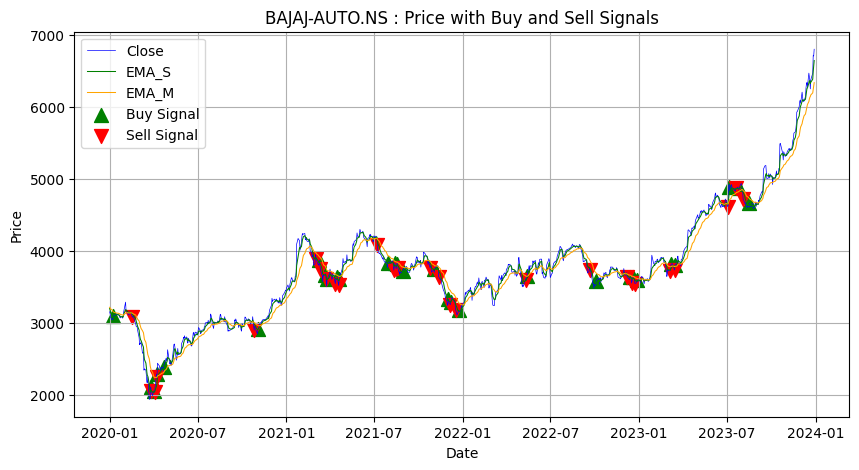

[*********************100%***********************]  1 of 1 completed



Order book for BAJFINANCE.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  24 Shares are bought at ₹4124.2001953125 on 2020-01-09 00:00:00
SELL:  24 Shares are sold at ₹4225.85009765625 on 2020-03-06 00:00:00
BUY:  36 Shares are bought at ₹2793.699951171875 on 2020-03-26 00:00:00
SELL:  36 Shares are sold at ₹2542.300048828125 on 2020-03-27 00:00:00
BUY:  40 Shares are bought at ₹2332.89990234375 on 2020-04-08 00:00:00
SELL:  40 Shares are sold at ₹2287.300048828125 on 2020-04-13 00:00:00
BUY:  39 Shares are bought at ₹2308.14990234375 on 2020-04-17 00:00:00
SELL:  39 Shares are sold at ₹2099.75 on 2020-04-21 00:00:00
BUY:  37 Shares are bought at ₹2228.10009765625 on 2020-04-28 00:00:00
SELL:  37 Shares are sold at ₹2079.64990234375 on 2020-05-04 00:00:00
BUY:  37 Shares are bought at ₹2069.699951171875 on 2020-05-12 00:00:00
SELL:  37 Shares are sold at ₹1938.5999755859375 on 2020-05-18 00:00:00
BUY:  35 Shares are bought at ₹2042.800048828

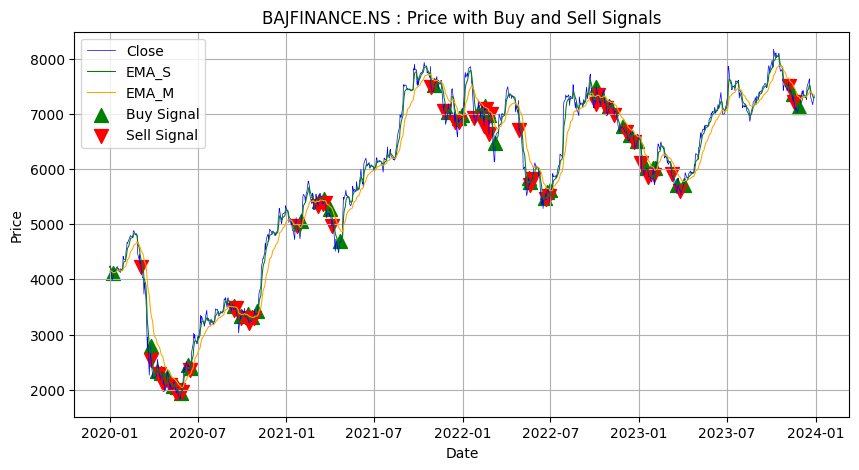

[*********************100%***********************]  1 of 1 completed



Order book for BAJAJFINSV.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  106 Shares are bought at ₹939.5250244140625 on 2020-01-09 00:00:00
SELL:  106 Shares are sold at ₹908.614990234375 on 2020-02-03 00:00:00
BUY:  101 Shares are bought at ₹953.489990234375 on 2020-02-04 00:00:00
SELL:  101 Shares are sold at ₹940.7999877929688 on 2020-02-27 00:00:00
BUY:  201 Shares are bought at ₹472.489990234375 on 2020-04-07 00:00:00
SELL:  201 Shares are sold at ₹460.8500061035156 on 2020-04-08 00:00:00
BUY:  193 Shares are bought at ₹482.0249938964844 on 2020-04-09 00:00:00
SELL:  193 Shares are sold at ₹449.1400146484375 on 2020-04-13 00:00:00
BUY:  184 Shares are bought at ₹469.9599914550781 on 2020-04-16 00:00:00
SELL:  184 Shares are sold at ₹459.5050048828125 on 2020-04-21 00:00:00
BUY:  177 Shares are bought at ₹477.57501220703125 on 2020-04-22 00:00:00
SELL:  177 Shares are sold at ₹438.9800109863281 on 2020-04-24 00:00:00
BUY:  160 Shares ar

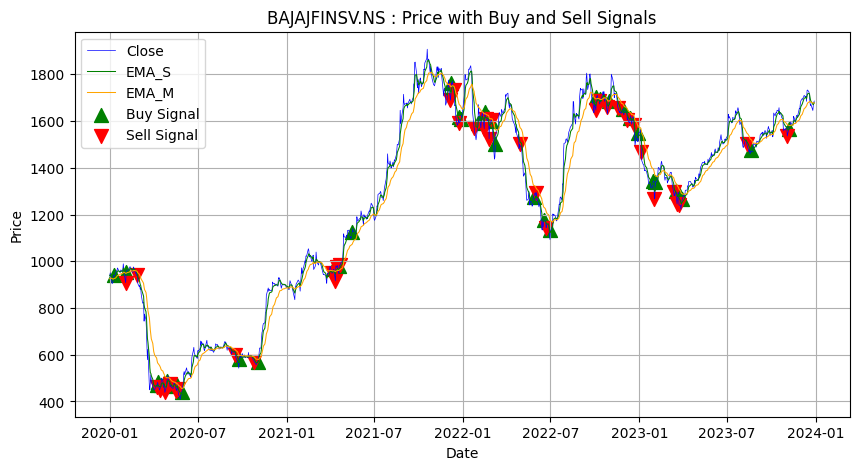

[*********************100%***********************]  1 of 1 completed



Order book for BEL.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  3061 Shares are bought at ₹32.666664123535156 on 2020-01-13 00:00:00
SELL:  3061 Shares are sold at ₹30.216665267944336 on 2020-01-31 00:00:00
BUY:  3276 Shares are bought at ₹28.233333587646484 on 2020-02-19 00:00:00
SELL:  3276 Shares are sold at ₹27.316665649414062 on 2020-02-24 00:00:00
BUY:  3841 Shares are bought at ₹23.299999237060547 on 2020-03-13 00:00:00
SELL:  3841 Shares are sold at ₹21.966665267944336 on 2020-03-16 00:00:00
BUY:  3631 Shares are bought at ₹23.233333587646484 on 2020-03-17 00:00:00
SELL:  3631 Shares are sold at ₹24.933332443237305 on 2020-03-18 00:00:00
BUY:  3809 Shares are bought at ₹23.766666412353516 on 2020-03-20 00:00:00
SELL:  3809 Shares are sold at ₹19.816665649414062 on 2020-03-23 00:00:00
BUY:  3363 Shares are bought at ₹22.450000762939453 on 2020-03-26 00:00:00
SELL:  3363 Shares are sold at ₹22.133333206176758 on 2020-04-08 00:00:00


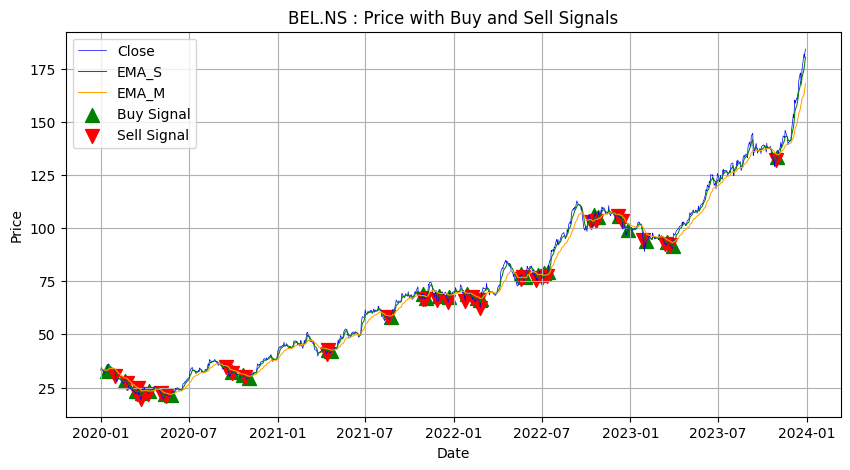

[*********************100%***********************]  1 of 1 completed



Order book for BPCL.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  425 Shares are bought at ₹235.27499389648438 on 2020-01-09 00:00:00
SELL:  425 Shares are sold at ₹230.89999389648438 on 2020-01-16 00:00:00
BUY:  423 Shares are bought at ₹231.9250030517578 on 2020-01-21 00:00:00
SELL:  423 Shares are sold at ₹227.72500610351562 on 2020-01-22 00:00:00
BUY:  410 Shares are bought at ₹234.5 on 2020-01-23 00:00:00
SELL:  410 Shares are sold at ₹228.47500610351562 on 2020-01-31 00:00:00
BUY:  392 Shares are bought at ₹239.25 on 2020-02-04 00:00:00
SELL:  392 Shares are sold at ₹234.5 on 2020-02-13 00:00:00
BUY:  387 Shares are bought at ₹237.77499389648438 on 2020-02-19 00:00:00
SELL:  387 Shares are sold at ₹232.3249969482422 on 2020-02-24 00:00:00
BUY:  424 Shares are bought at ₹211.9250030517578 on 2020-03-09 00:00:00
SELL:  424 Shares are sold at ₹202.1999969482422 on 2020-03-11 00:00:00
BUY:  541 Shares are bought at ₹158.4499969482422 on 

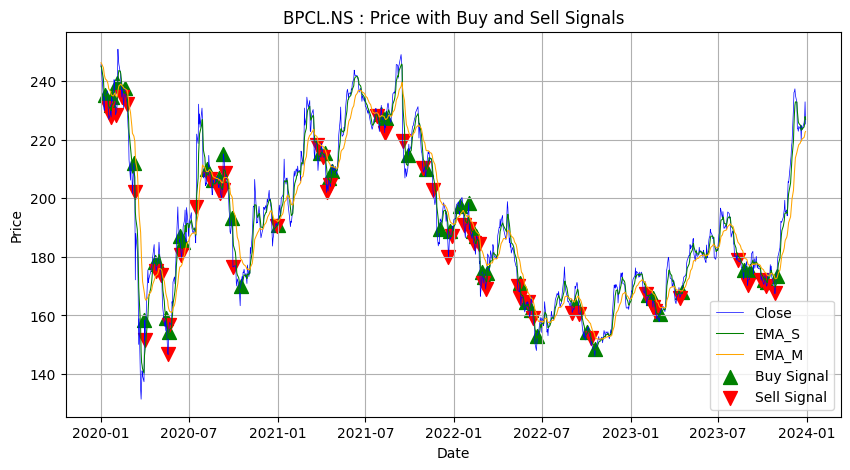

[*********************100%***********************]  1 of 1 completed



Order book for BHARTIARTL.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  222 Shares are bought at ₹450.39385986328125 on 2020-01-08 00:00:00
46 5
SELL:  222 Shares are sold at ₹509.58258056640625 on 2020-03-06 00:00:00
BUY:  249 Shares are bought at ₹454.1238098144531 on 2020-03-20 00:00:00
SELL:  249 Shares are sold at ₹399.84295654296875 on 2020-03-23 00:00:00
BUY:  236 Shares are bought at ₹421.1921081542969 on 2020-03-25 00:00:00
SELL:  236 Shares are sold at ₹462.0254821777344 on 2020-03-26 00:00:00
BUY:  252 Shares are bought at ₹432.774658203125 on 2020-03-31 00:00:00
SELL:  252 Shares are sold at ₹413.5849304199219 on 2020-04-01 00:00:00
BUY:  226 Shares are bought at ₹461.5346984863281 on 2020-04-07 00:00:00
SELL:  226 Shares are sold at ₹453.1422424316406 on 2020-04-08 00:00:00
BUY:  208 Shares are bought at ₹491.2762756347656 on 2020-04-21 00:00:00
SELL:  208 Shares are sold at ₹485.1414794921875 on 2020-04-24 00:00:00
BUY:  207 

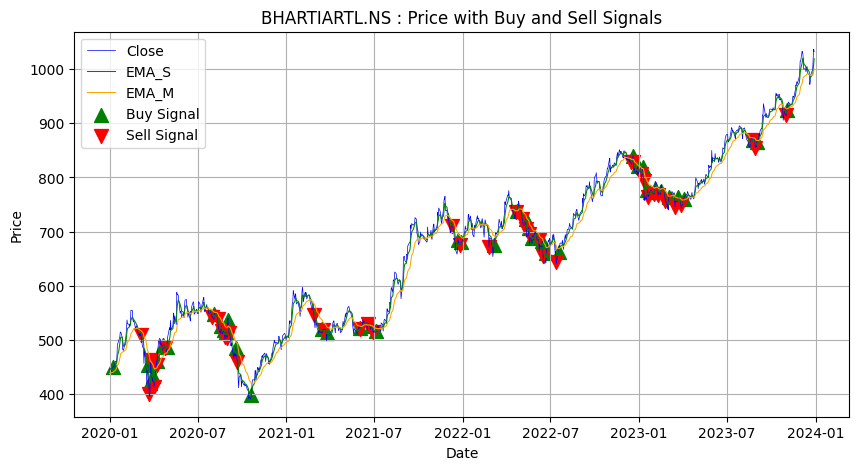

[*********************100%***********************]  1 of 1 completed



Order book for BRITANNIA.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  32 Shares are bought at ₹3045.10009765625 on 2020-01-13 00:00:00
SELL:  32 Shares are sold at ₹3026.050048828125 on 2020-02-27 00:00:00
BUY:  32 Shares are bought at ₹3026.5 on 2020-03-03 00:00:00
SELL:  32 Shares are sold at ₹3048.300048828125 on 2020-03-11 00:00:00
BUY:  40 Shares are bought at ₹2451.39990234375 on 2020-03-25 00:00:00
168 58
SELL:  40 Shares are sold at ₹3746.85009765625 on 2020-09-03 00:00:00
BUY:  40 Shares are bought at ₹3772.25 on 2020-09-11 00:00:00
SELL:  40 Shares are sold at ₹3629.300048828125 on 2020-09-21 00:00:00
BUY:  39 Shares are bought at ₹3686.39990234375 on 2020-09-25 00:00:00
SELL:  39 Shares are sold at ₹3553.14990234375 on 2020-10-20 00:00:00
BUY:  39 Shares are bought at ₹3572.25 on 2020-10-27 00:00:00
SELL:  39 Shares are sold at ₹3532.64990234375 on 2020-10-29 00:00:00
BUY:  40 Shares are bought at ₹3470.699951171875 on 2020-11-

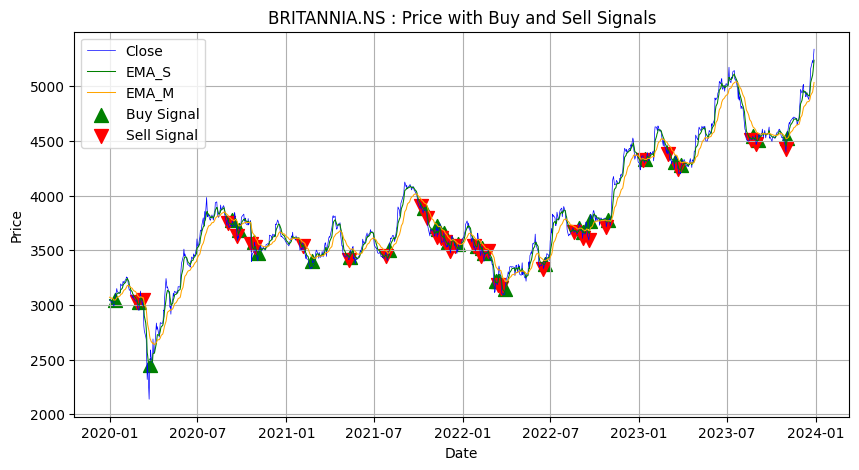

[*********************100%***********************]  1 of 1 completed



Order book for CIPLA.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  212 Shares are bought at ₹470.1000061035156 on 2020-01-09 00:00:00
SELL:  212 Shares are sold at ₹465.1499938964844 on 2020-01-23 00:00:00
BUY:  219 Shares are bought at ₹450.6000061035156 on 2020-02-11 00:00:00
SELL:  219 Shares are sold at ₹443.3999938964844 on 2020-02-13 00:00:00
BUY:  217 Shares are bought at ₹447.1000061035156 on 2020-02-14 00:00:00
SELL:  217 Shares are sold at ₹431.8999938964844 on 2020-02-17 00:00:00
BUY:  210 Shares are bought at ₹447.5 on 2020-02-19 00:00:00
SELL:  210 Shares are sold at ₹435.75 on 2020-02-20 00:00:00
BUY:  215 Shares are bought at ₹425.29998779296875 on 2020-03-03 00:00:00
SELL:  215 Shares are sold at ₹417.1000061035156 on 2020-03-11 00:00:00
BUY:  211 Shares are bought at ₹425.54998779296875 on 2020-03-13 00:00:00
SELL:  211 Shares are sold at ₹396.3999938964844 on 2020-03-16 00:00:00
BUY:  213 Shares are bought at ₹392.7999877

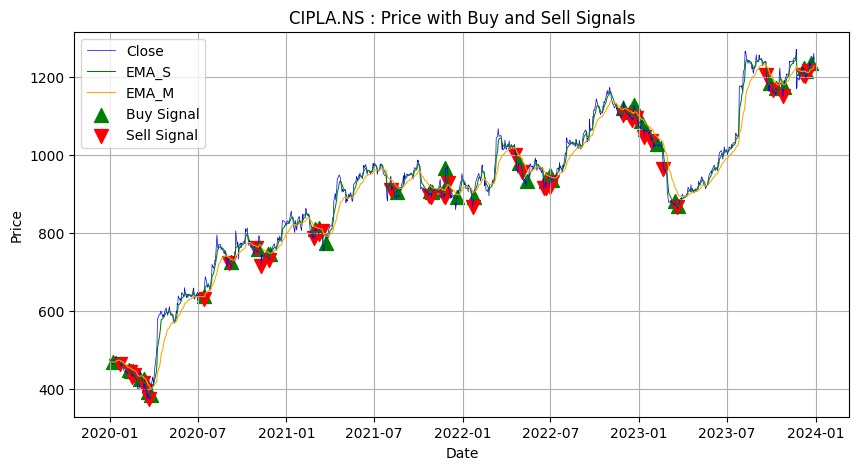

[*********************100%***********************]  1 of 1 completed



Order book for COALINDIA.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  487 Shares are bought at ₹205.3000030517578 on 2020-01-10 00:00:00
SELL:  487 Shares are sold at ₹201.14999389648438 on 2020-01-20 00:00:00
BUY:  529 Shares are bought at ₹185.0500030517578 on 2020-02-07 00:00:00
SELL:  529 Shares are sold at ₹178.85000610351562 on 2020-02-10 00:00:00
BUY:  532 Shares are bought at ₹177.75 on 2020-02-19 00:00:00
SELL:  532 Shares are sold at ₹174.85000610351562 on 2020-02-24 00:00:00
BUY:  522 Shares are bought at ₹178.1999969482422 on 2020-03-03 00:00:00
SELL:  522 Shares are sold at ₹178.10000610351562 on 2020-03-04 00:00:00
BUY:  706 Shares are bought at ₹131.6999969482422 on 2020-03-27 00:00:00
SELL:  706 Shares are sold at ₹133.14999389648438 on 2020-03-30 00:00:00
BUY:  668 Shares are bought at ₹140.8000030517578 on 2020-04-09 00:00:00
SELL:  668 Shares are sold at ₹139.0 on 2020-04-21 00:00:00
BUY:  664 Shares are bought at ₹139.

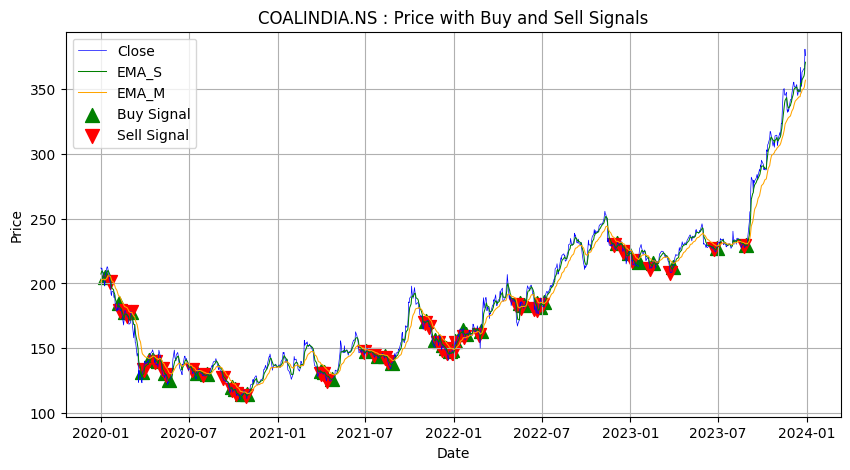

[*********************100%***********************]  1 of 1 completed



Order book for DRREDDY.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  34 Shares are bought at ₹2937.449951171875 on 2020-01-16 00:00:00
SELL:  34 Shares are sold at ₹2905.550048828125 on 2020-03-02 00:00:00
BUY:  32 Shares are bought at ₹3043.699951171875 on 2020-03-03 00:00:00
SELL:  32 Shares are sold at ₹2850.39990234375 on 2020-03-12 00:00:00
BUY:  32 Shares are bought at ₹2897.25 on 2020-03-20 00:00:00
SELL:  32 Shares are sold at ₹2768.39990234375 on 2020-03-23 00:00:00
BUY:  31 Shares are bought at ₹2857.949951171875 on 2020-03-24 00:00:00
SELL:  31 Shares are sold at ₹2922.0 on 2020-03-25 00:00:00
BUY:  22 Shares are bought at ₹3939.0 on 2020-05-04 00:00:00
SELL:  22 Shares are sold at ₹3833.89990234375 on 2020-05-05 00:00:00
BUY:  22 Shares are bought at ₹3984.0 on 2020-05-08 00:00:00
SELL:  22 Shares are sold at ₹3862.0 on 2020-05-11 00:00:00
BUY:  21 Shares are bought at ₹3910.199951171875 on 2020-05-20 00:00:00
SELL:  21 Shares 

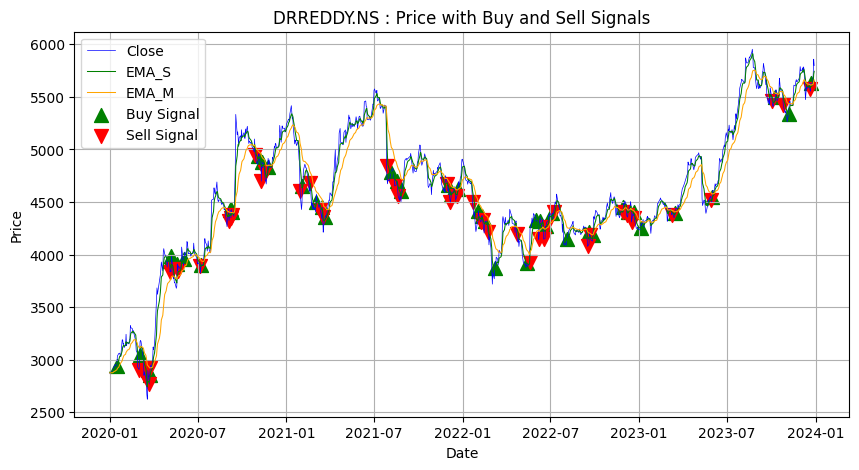

[*********************100%***********************]  1 of 1 completed



Order book for EICHERMOT.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  48 Shares are bought at ₹2048.969970703125 on 2020-01-14 00:00:00
SELL:  48 Shares are sold at ₹1988.344970703125 on 2020-02-03 00:00:00
BUY:  47 Shares are bought at ₹2039.1199951171875 on 2020-02-06 00:00:00
SELL:  47 Shares are sold at ₹1973.6300048828125 on 2020-02-07 00:00:00
BUY:  52 Shares are bought at ₹1788.844970703125 on 2020-03-03 00:00:00
SELL:  52 Shares are sold at ₹1725.4200439453125 on 2020-03-04 00:00:00
BUY:  51 Shares are bought at ₹1777.5350341796875 on 2020-03-05 00:00:00
SELL:  51 Shares are sold at ₹1774.35498046875 on 2020-03-06 00:00:00
BUY:  51 Shares are bought at ₹1767.2149658203125 on 2020-03-13 00:00:00
SELL:  51 Shares are sold at ₹1649.3699951171875 on 2020-03-16 00:00:00
BUY:  61 Shares are bought at ₹1374.22998046875 on 2020-04-09 00:00:00
SELL:  61 Shares are sold at ₹1340.0550537109375 on 2020-04-13 00:00:00
BUY:  61 Shares are bough

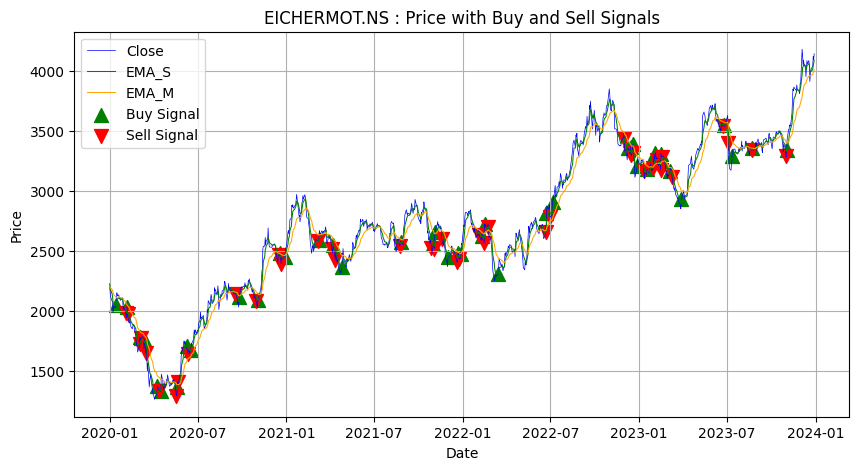

[*********************100%***********************]  1 of 1 completed



Order book for GRASIM.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  132 Shares are bought at ₹754.3007202148438 on 2020-01-09 00:00:00
SELL:  132 Shares are sold at ₹765.2073974609375 on 2020-01-17 00:00:00
BUY:  128 Shares are bought at ₹790.5565795898438 on 2020-02-04 00:00:00
SELL:  128 Shares are sold at ₹754.5497436523438 on 2020-02-10 00:00:00
BUY:  128 Shares are bought at ₹754.1513061523438 on 2020-02-19 00:00:00
SELL:  128 Shares are sold at ₹722.029052734375 on 2020-02-24 00:00:00
BUY:  132 Shares are bought at ₹697.2774658203125 on 2020-03-03 00:00:00
SELL:  132 Shares are sold at ₹686.769287109375 on 2020-03-04 00:00:00
BUY:  194 Shares are bought at ₹469.5330505371094 on 2020-03-26 00:00:00
SELL:  194 Shares are sold at ₹459.0746154785156 on 2020-03-27 00:00:00
BUY:  188 Shares are bought at ₹474.21441650390625 on 2020-03-31 00:00:00
SELL:  188 Shares are sold at ₹474.26422119140625 on 2020-04-01 00:00:00
BUY:  172 Shares are 

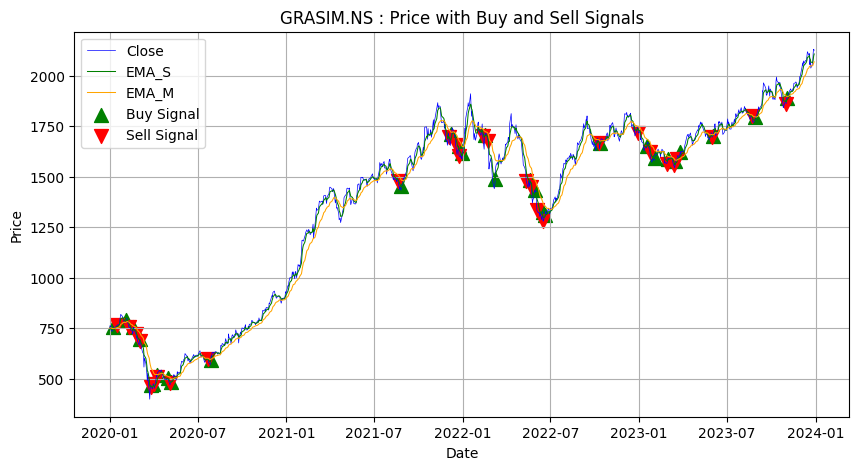

[*********************100%***********************]  1 of 1 completed



Order book for HCLTECH.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  170 Shares are bought at ₹586.5 on 2020-01-13 00:00:00
SELL:  170 Shares are sold at ₹573.0499877929688 on 2020-02-27 00:00:00
BUY:  172 Shares are bought at ₹565.0499877929688 on 2020-03-03 00:00:00
SELL:  172 Shares are sold at ₹540.4500122070312 on 2020-03-09 00:00:00
BUY:  211 Shares are bought at ₹442.04998779296875 on 2020-03-24 00:00:00
SELL:  211 Shares are sold at ₹457.6000061035156 on 2020-03-25 00:00:00
BUY:  221 Shares are bought at ₹436.3999938964844 on 2020-03-31 00:00:00
SELL:  221 Shares are sold at ₹413.54998779296875 on 2020-04-01 00:00:00
BUY:  203 Shares are bought at ₹451.1499938964844 on 2020-04-07 00:00:00
215 65
SELL:  203 Shares are sold at ₹809.7000122070312 on 2020-11-10 00:00:00
BUY:  198 Shares are bought at ₹830.5 on 2020-11-14 00:00:00
SELL:  198 Shares are sold at ₹814.2999877929688 on 2020-11-18 00:00:00
BUY:  196 Shares are bought at ₹819

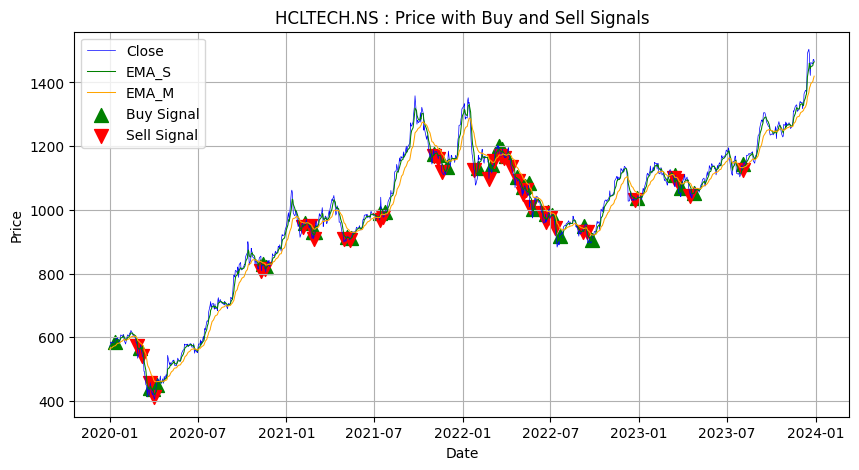

[*********************100%***********************]  1 of 1 completed



Order book for HDFCBANK.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  78 Shares are bought at ₹1271.4000244140625 on 2020-01-09 00:00:00
SELL:  78 Shares are sold at ₹1244.3499755859375 on 2020-01-21 00:00:00
BUY:  79 Shares are bought at ₹1235.8499755859375 on 2020-01-29 00:00:00
SELL:  79 Shares are sold at ₹1192.800048828125 on 2020-02-03 00:00:00
BUY:  76 Shares are bought at ₹1229.800048828125 on 2020-02-04 00:00:00
SELL:  76 Shares are sold at ₹1213.25 on 2020-02-18 00:00:00
BUY:  75 Shares are bought at ₹1227.199951171875 on 2020-02-19 00:00:00
SELL:  75 Shares are sold at ₹1209.949951171875 on 2020-02-24 00:00:00
BUY:  107 Shares are bought at ₹856.75 on 2020-03-25 00:00:00
SELL:  107 Shares are sold at ₹831.6500244140625 on 2020-03-30 00:00:00
BUY:  99 Shares are bought at ₹896.0999755859375 on 2020-04-07 00:00:00
SELL:  99 Shares are sold at ₹888.9000244140625 on 2020-04-08 00:00:00
BUY:  97 Shares are bought at ₹910.299987792968

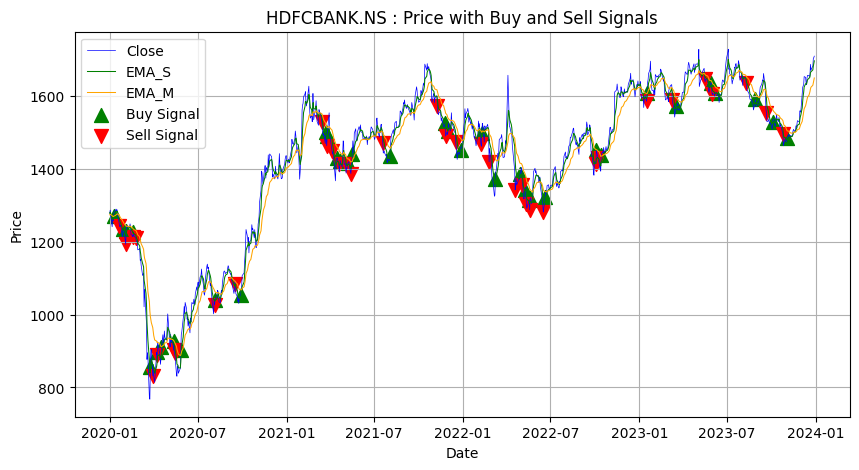

[*********************100%***********************]  1 of 1 completed



Order book for HDFCLIFE.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  158 Shares are bought at ₹629.9500122070312 on 2020-01-07 00:00:00
SELL:  158 Shares are sold at ₹614.25 on 2020-01-14 00:00:00
BUY:  159 Shares are bought at ₹612.75 on 2020-01-22 00:00:00
SELL:  159 Shares are sold at ₹599.7000122070312 on 2020-01-27 00:00:00
BUY:  160 Shares are bought at ₹593.6500244140625 on 2020-02-06 00:00:00
SELL:  160 Shares are sold at ₹583.5 on 2020-02-11 00:00:00
BUY:  162 Shares are bought at ₹579.0999755859375 on 2020-02-19 00:00:00
SELL:  162 Shares are sold at ₹560.7999877929688 on 2020-02-24 00:00:00
BUY:  159 Shares are bought at ₹569.5 on 2020-02-25 00:00:00
SELL:  159 Shares are sold at ₹557.0499877929688 on 2020-02-26 00:00:00
BUY:  156 Shares are bought at ₹566.7000122070312 on 2020-02-27 00:00:00
SELL:  156 Shares are sold at ₹544.0999755859375 on 2020-02-28 00:00:00
BUY:  151 Shares are bought at ₹563.5 on 2020-03-03 00:00:00
SELL

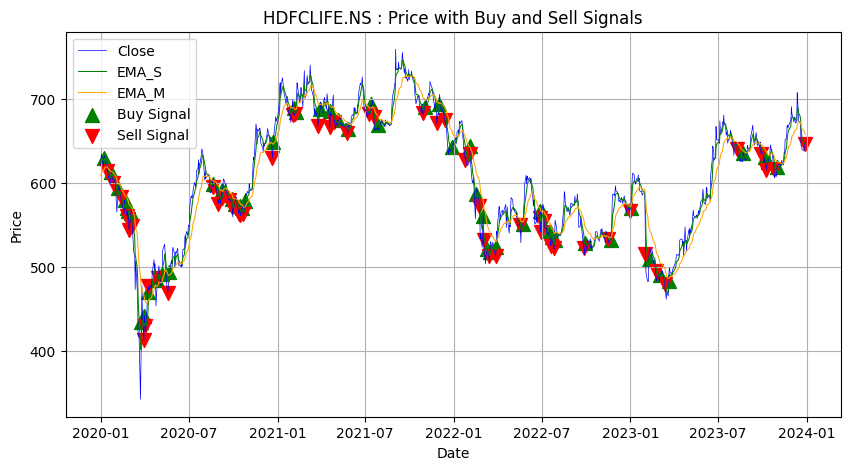

[*********************100%***********************]  1 of 1 completed



Order book for HEROMOTOCO.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  42 Shares are bought at ₹2363.449951171875 on 2020-01-10 00:00:00
SELL:  42 Shares are sold at ₹2283.35009765625 on 2020-02-17 00:00:00
BUY:  46 Shares are bought at ₹2063.89990234375 on 2020-03-05 00:00:00
SELL:  46 Shares are sold at ₹2038.300048828125 on 2020-03-06 00:00:00
BUY:  46 Shares are bought at ₹2036.050048828125 on 2020-03-11 00:00:00
SELL:  46 Shares are sold at ₹1907.199951171875 on 2020-03-12 00:00:00
BUY:  49 Shares are bought at ₹1815.699951171875 on 2020-03-20 00:00:00
SELL:  49 Shares are sold at ₹1616.0 on 2020-03-23 00:00:00
BUY:  44 Shares are bought at ₹1801.9000244140625 on 2020-03-26 00:00:00
SELL:  44 Shares are sold at ₹1661.199951171875 on 2020-03-27 00:00:00
BUY:  44 Shares are bought at ₹1639.6500244140625 on 2020-04-01 00:00:00
SELL:  44 Shares are sold at ₹1582.050048828125 on 2020-04-03 00:00:00
BUY:  40 Shares are bought at ₹1769.1999

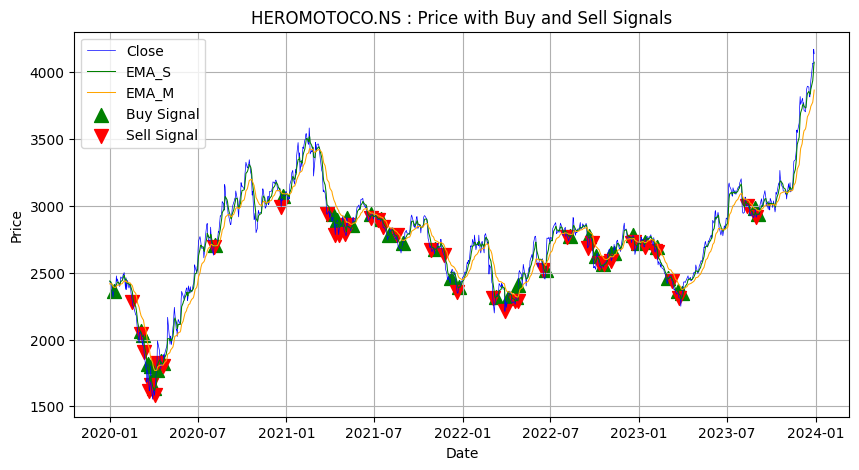

[*********************100%***********************]  1 of 1 completed



Order book for HINDALCO.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  472 Shares are bought at ₹211.5 on 2020-01-10 00:00:00
SELL:  472 Shares are sold at ₹207.3000030517578 on 2020-01-20 00:00:00
BUY:  499 Shares are bought at ₹196.3000030517578 on 2020-02-05 00:00:00
SELL:  499 Shares are sold at ₹190.85000610351562 on 2020-02-10 00:00:00
BUY:  492 Shares are bought at ₹193.64999389648438 on 2020-02-11 00:00:00
SELL:  492 Shares are sold at ₹190.25 on 2020-02-17 00:00:00
BUY:  492 Shares are bought at ₹189.9499969482422 on 2020-02-20 00:00:00
SELL:  492 Shares are sold at ₹179.0500030517578 on 2020-02-24 00:00:00
BUY:  922 Shares are bought at ₹95.69999694824219 on 2020-03-31 00:00:00
SELL:  922 Shares are sold at ₹91.6500015258789 on 2020-04-01 00:00:00
BUY:  813 Shares are bought at ₹103.94999694824219 on 2020-04-07 00:00:00
SELL:  813 Shares are sold at ₹100.8499984741211 on 2020-04-08 00:00:00
BUY:  754 Shares are bought at ₹108.75 o

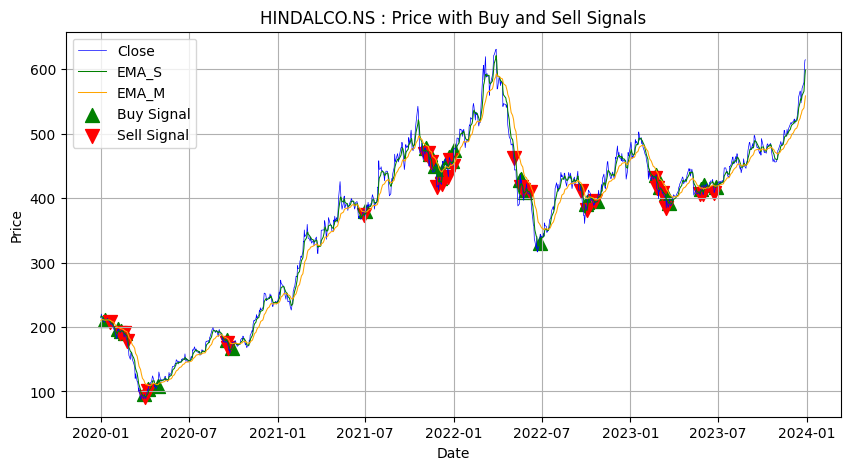

[*********************100%***********************]  1 of 1 completed



Order book for HINDUNILVR.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  51 Shares are bought at ₹1929.3499755859375 on 2020-01-08 00:00:00
SELL:  51 Shares are sold at ₹2033.199951171875 on 2020-03-13 00:00:00
BUY:  51 Shares are bought at ₹2051.699951171875 on 2020-03-20 00:00:00
SELL:  51 Shares are sold at ₹1869.699951171875 on 2020-03-23 00:00:00
BUY:  47 Shares are bought at ₹2027.8499755859375 on 2020-03-24 00:00:00
SELL:  47 Shares are sold at ₹1992.050048828125 on 2020-05-07 00:00:00
BUY:  45 Shares are bought at ₹2089.449951171875 on 2020-05-08 00:00:00
SELL:  45 Shares are sold at ₹2048.0 on 2020-05-11 00:00:00
BUY:  45 Shares are bought at ₹2032.0999755859375 on 2020-05-15 00:00:00
SELL:  45 Shares are sold at ₹2005.25 on 2020-05-18 00:00:00
BUY:  45 Shares are bought at ₹1998.0999755859375 on 2020-05-27 00:00:00
150 97
SELL:  45 Shares are sold at ₹2206.75 on 2020-08-10 00:00:00
BUY:  45 Shares are bought at ₹2210.64990234375 o

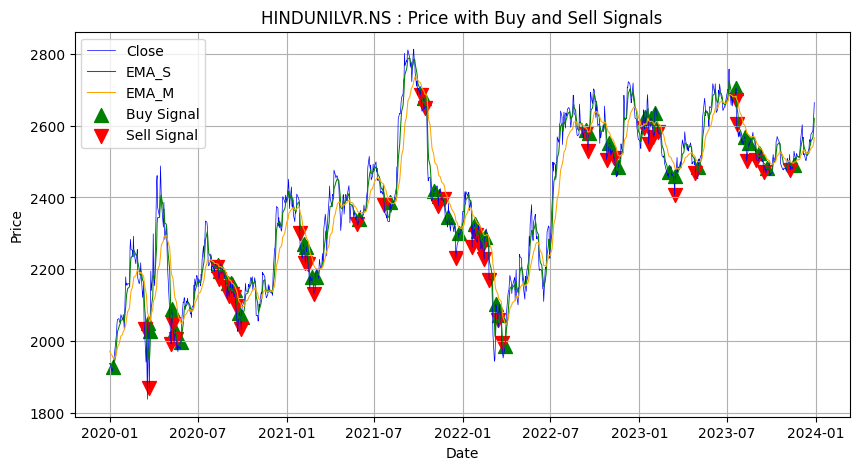

[*********************100%***********************]  1 of 1 completed



Order book for ICICIBANK.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  183 Shares are bought at ₹546.2999877929688 on 2020-01-09 00:00:00
SELL:  183 Shares are sold at ₹537.5999755859375 on 2020-01-14 00:00:00
BUY:  183 Shares are bought at ₹537.1500244140625 on 2020-01-16 00:00:00
SELL:  183 Shares are sold at ₹522.8499755859375 on 2020-01-22 00:00:00
BUY:  179 Shares are bought at ₹533.8499755859375 on 2020-01-24 00:00:00
SELL:  179 Shares are sold at ₹525.6500244140625 on 2020-01-31 00:00:00
BUY:  177 Shares are bought at ₹530.7999877929688 on 2020-02-04 00:00:00
SELL:  177 Shares are sold at ₹515.3499755859375 on 2020-02-27 00:00:00
BUY:  177 Shares are bought at ₹514.75 on 2020-03-03 00:00:00
SELL:  177 Shares are sold at ₹508.3500061035156 on 2020-03-04 00:00:00
BUY:  273 Shares are bought at ₹330.25 on 2020-03-26 00:00:00
SELL:  273 Shares are sold at ₹313.3999938964844 on 2020-03-30 00:00:00
BUY:  263 Shares are bought at ₹326.1000

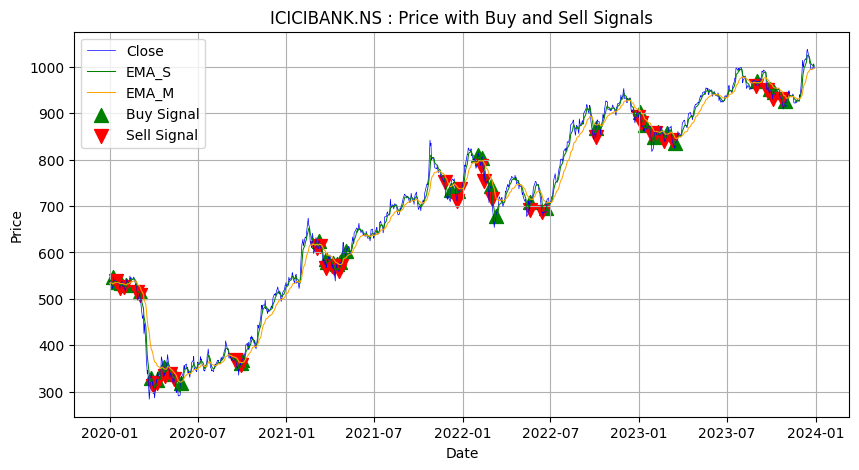

[*********************100%***********************]  1 of 1 completed



Order book for INDUSINDBK.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  66 Shares are bought at ₹1507.6500244140625 on 2020-01-09 00:00:00
SELL:  66 Shares are sold at ₹1481.6500244140625 on 2020-01-14 00:00:00
BUY:  77 Shares are bought at ₹1272.6500244140625 on 2020-02-04 00:00:00
SELL:  77 Shares are sold at ₹1230.75 on 2020-02-13 00:00:00
BUY:  80 Shares are bought at ₹1182.199951171875 on 2020-02-20 00:00:00
SELL:  80 Shares are sold at ₹1170.25 on 2020-02-24 00:00:00
BUY:  215 Shares are bought at ₹435.8999938964844 on 2020-03-26 00:00:00
SELL:  215 Shares are sold at ₹411.1000061035156 on 2020-03-27 00:00:00
BUY:  231 Shares are bought at ₹383.8500061035156 on 2020-04-07 00:00:00
SELL:  231 Shares are sold at ₹399.1499938964844 on 2020-04-08 00:00:00
BUY:  226 Shares are bought at ₹407.3999938964844 on 2020-04-27 00:00:00
SELL:  226 Shares are sold at ₹376.75 on 2020-05-18 00:00:00
BUY:  231 Shares are bought at ₹368.95001220703125 

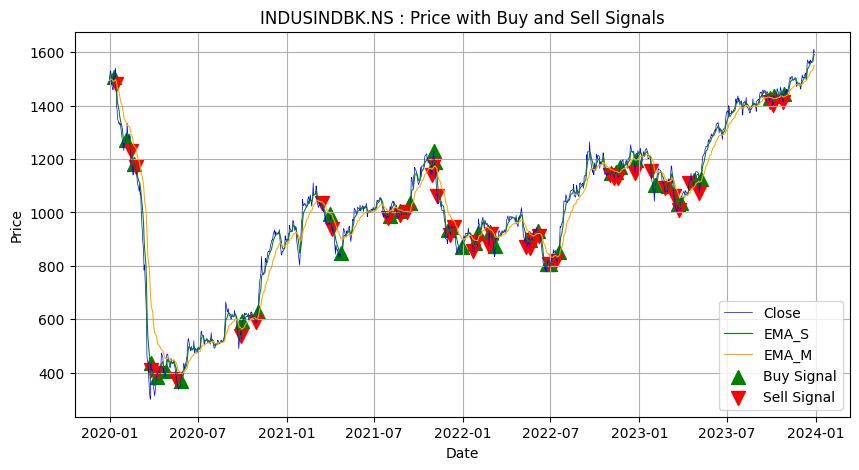

[*********************100%***********************]  1 of 1 completed



Order book for INFY.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  135 Shares are bought at ₹738.1500244140625 on 2020-01-10 00:00:00
SELL:  135 Shares are sold at ₹731.7000122070312 on 2020-02-28 00:00:00
BUY:  130 Shares are bought at ₹758.75 on 2020-03-04 00:00:00
SELL:  130 Shares are sold at ₹738.9500122070312 on 2020-03-06 00:00:00
BUY:  164 Shares are bought at ₹585.2000122070312 on 2020-03-20 00:00:00
SELL:  164 Shares are sold at ₹526.4500122070312 on 2020-03-23 00:00:00
BUY:  147 Shares are bought at ₹589.7999877929688 on 2020-03-24 00:00:00
SELL:  147 Shares are sold at ₹606.2000122070312 on 2020-03-25 00:00:00
BUY:  139 Shares are bought at ₹639.0 on 2020-04-07 00:00:00
SELL:  139 Shares are sold at ₹637.4000244140625 on 2020-04-13 00:00:00
BUY:  136 Shares are bought at ₹653.2999877929688 on 2020-04-20 00:00:00
SELL:  136 Shares are sold at ₹633.2000122070312 on 2020-04-21 00:00:00
BUY:  134 Shares are bought at ₹641.8499755859

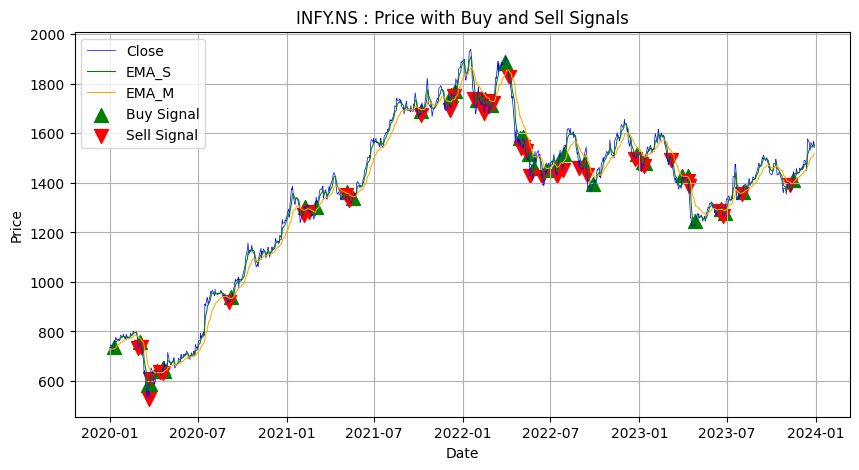

[*********************100%***********************]  1 of 1 completed



Order book for ITC.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  420 Shares are bought at ₹238.0 on 2020-01-10 00:00:00
SELL:  420 Shares are sold at ₹230.75 on 2020-01-28 00:00:00
BUY:  409 Shares are bought at ₹236.64999389648438 on 2020-01-29 00:00:00
SELL:  409 Shares are sold at ₹207.60000610351562 on 2020-02-03 00:00:00
BUY:  410 Shares are bought at ₹207.4499969482422 on 2020-02-20 00:00:00
SELL:  410 Shares are sold at ₹203.0 on 2020-02-24 00:00:00
BUY:  514 Shares are bought at ₹161.85000610351562 on 2020-03-19 00:00:00
SELL:  514 Shares are sold at ₹154.3000030517578 on 2020-03-23 00:00:00
BUY:  507 Shares are bought at ₹156.39999389648438 on 2020-03-26 00:00:00
89 59
SELL:  507 Shares are sold at ₹163.8000030517578 on 2020-05-14 00:00:00
BUY:  504 Shares are bought at ₹164.64999389648438 on 2020-05-15 00:00:00
143 90
SELL:  504 Shares are sold at ₹193.35000610351562 on 2020-07-30 00:00:00
BUY:  499 Shares are bought at ₹195.3500

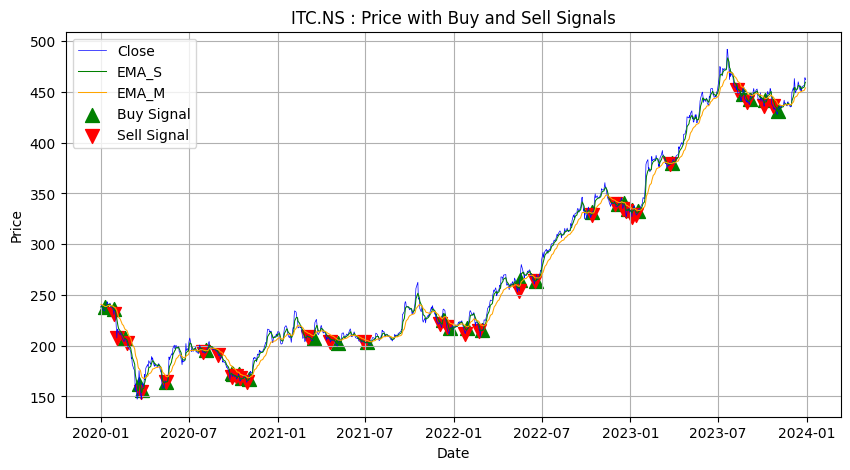

[*********************100%***********************]  1 of 1 completed



Order book for JSWSTEEL.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  359 Shares are bought at ₹278.1000061035156 on 2020-01-09 00:00:00
SELL:  359 Shares are sold at ₹271.3500061035156 on 2020-01-20 00:00:00
BUY:  358 Shares are bought at ₹271.8999938964844 on 2020-01-24 00:00:00
SELL:  358 Shares are sold at ₹262.79998779296875 on 2020-01-27 00:00:00
BUY:  365 Shares are bought at ₹258.3500061035156 on 2020-02-04 00:00:00
SELL:  365 Shares are sold at ₹252.10000610351562 on 2020-02-27 00:00:00
BUY:  372 Shares are bought at ₹247.14999389648438 on 2020-03-05 00:00:00
SELL:  372 Shares are sold at ₹238.8000030517578 on 2020-03-06 00:00:00
BUY:  562 Shares are bought at ₹158.10000610351562 on 2020-04-07 00:00:00
SELL:  562 Shares are sold at ₹154.60000610351562 on 2020-04-08 00:00:00
BUY:  545 Shares are bought at ₹159.39999389648438 on 2020-04-28 00:00:00
371 78
SELL:  545 Shares are sold at ₹685.9000244140625 on 2021-06-29 00:00:00
BUY:  

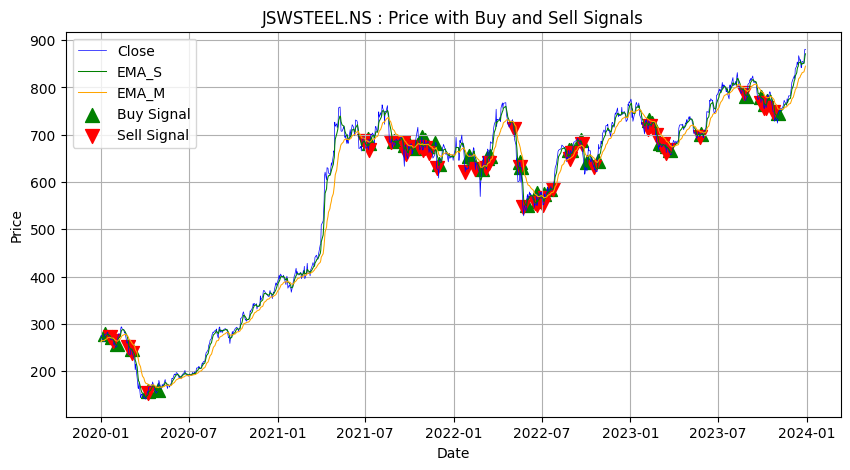

[*********************100%***********************]  1 of 1 completed



Order book for KOTAKBANK.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  59 Shares are bought at ₹1670.8499755859375 on 2020-01-07 00:00:00
SELL:  59 Shares are sold at ₹1617.9000244140625 on 2020-01-20 00:00:00
BUY:  58 Shares are bought at ₹1642.949951171875 on 2020-01-24 00:00:00
SELL:  58 Shares are sold at ₹1618.3499755859375 on 2020-01-27 00:00:00
BUY:  58 Shares are bought at ₹1626.050048828125 on 2020-01-28 00:00:00
SELL:  58 Shares are sold at ₹1599.0 on 2020-03-02 00:00:00
BUY:  56 Shares are bought at ₹1651.3499755859375 on 2020-03-05 00:00:00
SELL:  56 Shares are sold at ₹1631.050048828125 on 2020-03-06 00:00:00
BUY:  71 Shares are bought at ₹1290.1500244140625 on 2020-03-25 00:00:00
SELL:  71 Shares are sold at ₹1372.949951171875 on 2020-03-26 00:00:00
BUY:  77 Shares are bought at ₹1272.9000244140625 on 2020-04-09 00:00:00
SELL:  77 Shares are sold at ₹1250.9000244140625 on 2020-04-13 00:00:00
BUY:  77 Shares are bought at ₹124

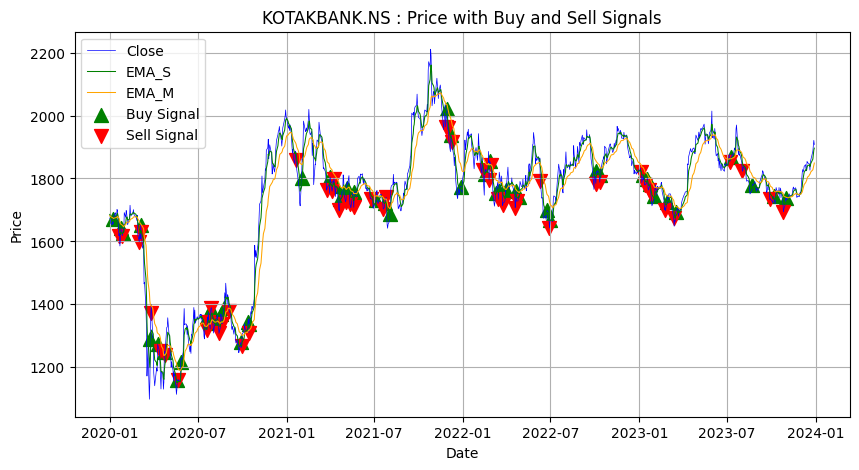

[*********************100%***********************]  1 of 1 completed



Order book for LT.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  75 Shares are bought at ₹1316.1500244140625 on 2020-01-09 00:00:00
SELL:  75 Shares are sold at ₹1286.6500244140625 on 2020-02-03 00:00:00
BUY:  74 Shares are bought at ₹1317.5999755859375 on 2020-02-06 00:00:00
SELL:  74 Shares are sold at ₹1285.300048828125 on 2020-02-10 00:00:00
BUY:  113 Shares are bought at ₹838.0 on 2020-03-26 00:00:00
SELL:  113 Shares are sold at ₹837.0499877929688 on 2020-03-27 00:00:00
BUY:  118 Shares are bought at ₹801.6500244140625 on 2020-04-07 00:00:00
91 65
SELL:  118 Shares are sold at ₹813.3499755859375 on 2020-05-18 00:00:00
BUY:  115 Shares are bought at ₹835.0 on 2020-05-20 00:00:00
SELL:  115 Shares are sold at ₹820.5 on 2020-05-21 00:00:00
BUY:  115 Shares are bought at ₹825.5499877929688 on 2020-05-26 00:00:00
135 96
SELL:  115 Shares are sold at ₹919.5999755859375 on 2020-07-20 00:00:00
BUY:  112 Shares are bought at ₹938.0499877929688

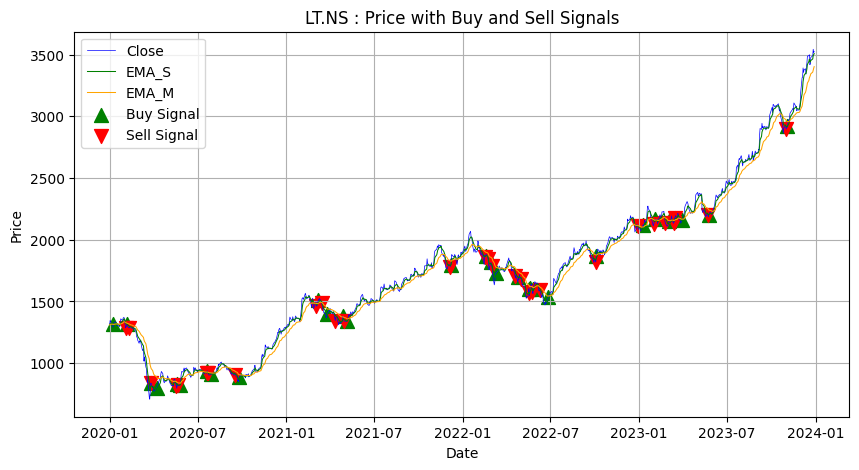

[*********************100%***********************]  1 of 1 completed



Order book for M&M.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  184 Shares are bought at ₹541.25 on 2020-01-09 00:00:00
SELL:  184 Shares are sold at ₹528.4000244140625 on 2020-02-10 00:00:00
BUY:  203 Shares are bought at ₹479.29998779296875 on 2020-03-05 00:00:00
SELL:  203 Shares are sold at ₹471.0 on 2020-03-06 00:00:00
BUY:  298 Shares are bought at ₹321.0 on 2020-04-07 00:00:00
SELL:  298 Shares are sold at ₹326.3999938964844 on 2020-04-08 00:00:00
BUY:  280 Shares are bought at ₹347.5 on 2020-04-23 00:00:00
SELL:  280 Shares are sold at ₹334.29998779296875 on 2020-04-24 00:00:00
BUY:  269 Shares are bought at ₹348.0 on 2020-04-29 00:00:00
187 79
SELL:  269 Shares are sold at ₹607.9000244140625 on 2020-09-30 00:00:00
BUY:  268 Shares are bought at ₹610.1500244140625 on 2020-10-01 00:00:00
SELL:  268 Shares are sold at ₹607.0 on 2020-10-05 00:00:00
BUY:  259 Shares are bought at ₹627.4000244140625 on 2020-10-06 00:00:00
SELL:  259 Sh

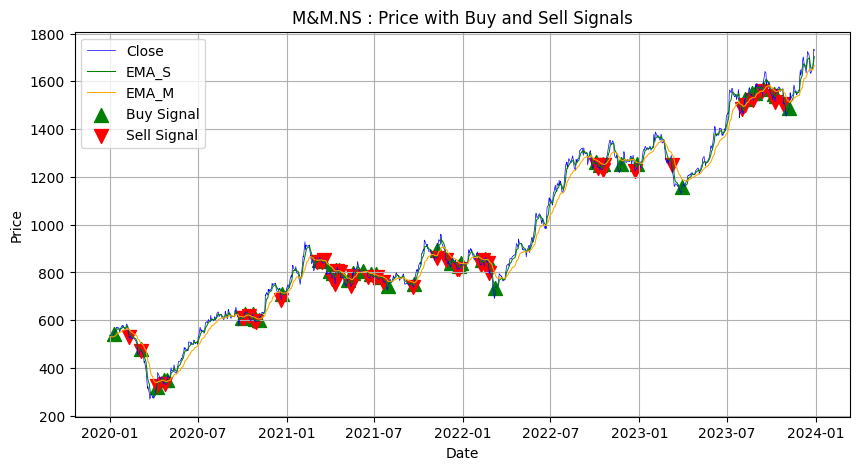

[*********************100%***********************]  1 of 1 completed



Order book for MARUTI.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  13 Shares are bought at ₹7227.89990234375 on 2020-01-09 00:00:00
SELL:  13 Shares are sold at ₹7148.7998046875 on 2020-01-27 00:00:00
BUY:  13 Shares are bought at ₹7199.60009765625 on 2020-02-04 00:00:00
SELL:  13 Shares are sold at ₹7040.89990234375 on 2020-02-05 00:00:00
BUY:  13 Shares are bought at ₹7033.75 on 2020-02-11 00:00:00
SELL:  13 Shares are sold at ₹6906.75 on 2020-02-17 00:00:00
BUY:  14 Shares are bought at ₹6386.0498046875 on 2020-03-03 00:00:00
SELL:  14 Shares are sold at ₹6384.35009765625 on 2020-03-04 00:00:00
BUY:  14 Shares are bought at ₹6445.9501953125 on 2020-03-06 00:00:00
SELL:  14 Shares are sold at ₹6201.10009765625 on 2020-03-09 00:00:00
BUY:  18 Shares are bought at ₹5005.9501953125 on 2020-03-25 00:00:00
SELL:  18 Shares are sold at ₹4878.0 on 2020-03-26 00:00:00
BUY:  19 Shares are bought at ₹4553.64990234375 on 2020-04-07 00:00:00
SELL: 

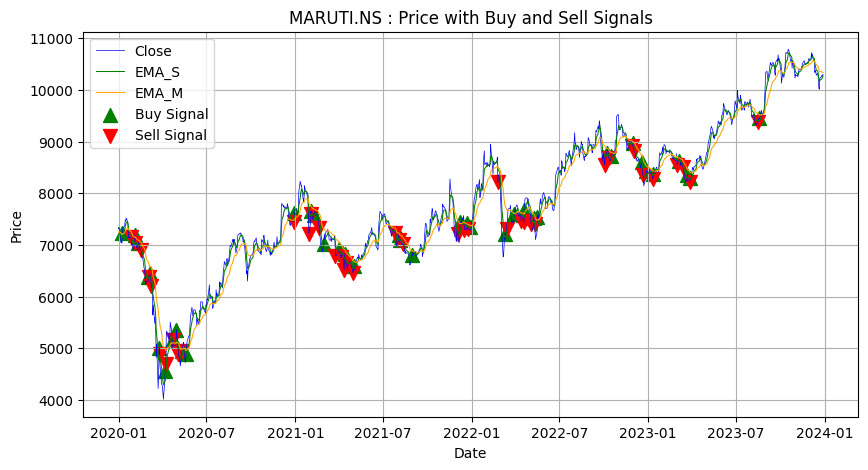

[*********************100%***********************]  1 of 1 completed



Order book for NESTLEIND.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  68 Shares are bought at ₹1464.344970703125 on 2020-01-09 00:00:00
SELL:  68 Shares are sold at ₹1499.1800537109375 on 2020-03-13 00:00:00
BUY:  72 Shares are bought at ₹1414.550048828125 on 2020-03-20 00:00:00
SELL:  72 Shares are sold at ₹1294.4649658203125 on 2020-03-23 00:00:00
BUY:  64 Shares are bought at ₹1444.4100341796875 on 2020-03-25 00:00:00
SELL:  64 Shares are sold at ₹1491.9649658203125 on 2020-03-26 00:00:00
BUY:  56 Shares are bought at ₹1703.864990234375 on 2020-04-07 00:00:00
SELL:  56 Shares are sold at ₹1687.125 on 2020-04-08 00:00:00
BUY:  54 Shares are bought at ₹1764.2049560546875 on 2020-04-22 00:00:00
SELL:  54 Shares are sold at ₹1742.1500244140625 on 2020-05-05 00:00:00
BUY:  53 Shares are bought at ₹1780.2950439453125 on 2020-05-08 00:00:00
SELL:  53 Shares are sold at ₹1746.1949462890625 on 2020-05-12 00:00:00
BUY:  55 Shares are bought at ₹

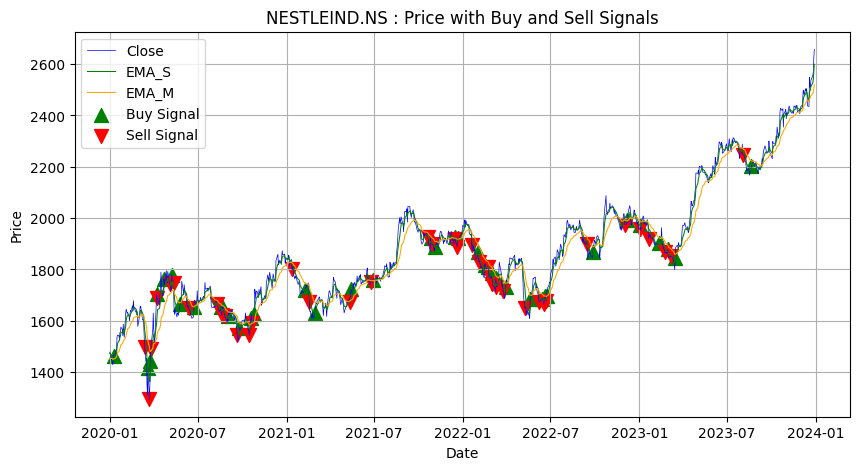

[*********************100%***********************]  1 of 1 completed



Order book for NTPC.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  829 Shares are bought at ₹120.55000305175781 on 2020-01-07 00:00:00
SELL:  829 Shares are sold at ₹119.94999694824219 on 2020-01-08 00:00:00
BUY:  827 Shares are bought at ₹120.30000305175781 on 2020-01-10 00:00:00
SELL:  827 Shares are sold at ₹118.25 on 2020-01-20 00:00:00
BUY:  860 Shares are bought at ₹113.6500015258789 on 2020-01-30 00:00:00
SELL:  860 Shares are sold at ₹110.25 on 2020-02-03 00:00:00
BUY:  847 Shares are bought at ₹112.0 on 2020-02-06 00:00:00
SELL:  847 Shares are sold at ₹110.30000305175781 on 2020-02-17 00:00:00
BUY:  833 Shares are bought at ₹112.05000305175781 on 2020-02-19 00:00:00
SELL:  833 Shares are sold at ₹109.69999694824219 on 2020-02-24 00:00:00
BUY:  840 Shares are bought at ₹108.9000015258789 on 2020-03-03 00:00:00
SELL:  840 Shares are sold at ₹105.1500015258789 on 2020-03-06 00:00:00
BUY:  1064 Shares are bought at ₹83.0 on 2020-03-27

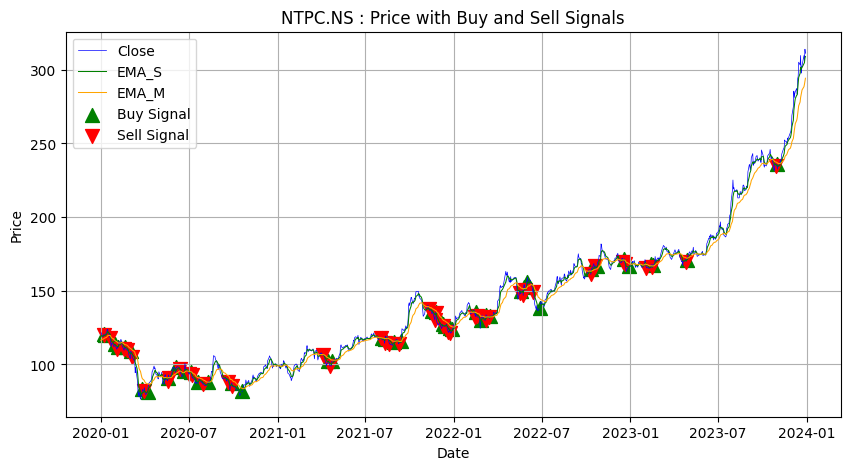

[*********************100%***********************]  1 of 1 completed



Order book for ONGC.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  797 Shares are bought at ₹125.44999694824219 on 2020-01-13 00:00:00
SELL:  797 Shares are sold at ₹122.9000015258789 on 2020-01-20 00:00:00
BUY:  896 Shares are bought at ₹109.25 on 2020-02-07 00:00:00
SELL:  896 Shares are sold at ₹106.19999694824219 on 2020-02-10 00:00:00
BUY:  926 Shares are bought at ₹102.80000305175781 on 2020-02-20 00:00:00
SELL:  926 Shares are sold at ₹98.05000305175781 on 2020-02-24 00:00:00
BUY:  973 Shares are bought at ₹93.3499984741211 on 2020-03-03 00:00:00
SELL:  973 Shares are sold at ₹92.80000305175781 on 2020-03-04 00:00:00
BUY:  1325 Shares are bought at ₹68.1500015258789 on 2020-03-18 00:00:00
SELL:  1325 Shares are sold at ₹61.04999923706055 on 2020-03-19 00:00:00
BUY:  1118 Shares are bought at ₹72.3499984741211 on 2020-03-20 00:00:00
SELL:  1118 Shares are sold at ₹60.400001525878906 on 2020-03-23 00:00:00
BUY:  1042 Shares are bought 

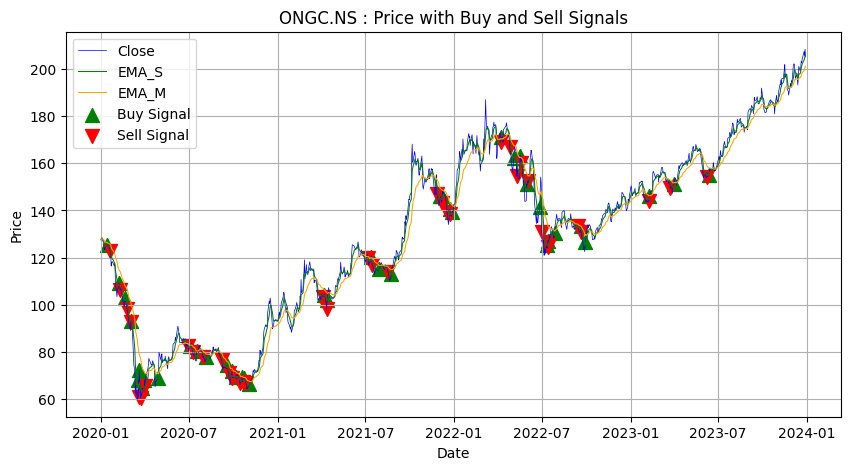

[*********************100%***********************]  1 of 1 completed



Order book for POWERGRID.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  921 Shares are bought at ₹108.5344009399414 on 2020-01-09 00:00:00
SELL:  921 Shares are sold at ₹105.1031494140625 on 2020-01-31 00:00:00
BUY:  885 Shares are bought at ₹109.3218994140625 on 2020-02-04 00:00:00
SELL:  885 Shares are sold at ₹106.5093994140625 on 2020-02-05 00:00:00
BUY:  869 Shares are bought at ₹108.50627899169922 on 2020-02-06 00:00:00
SELL:  869 Shares are sold at ₹107.10002899169922 on 2020-02-07 00:00:00
BUY:  868 Shares are bought at ₹107.18440246582031 on 2020-02-13 00:00:00
SELL:  868 Shares are sold at ₹103.5562744140625 on 2020-02-14 00:00:00
BUY:  853 Shares are bought at ₹105.4687728881836 on 2020-02-19 00:00:00
SELL:  853 Shares are sold at ₹104.8781509399414 on 2020-02-27 00:00:00
BUY:  829 Shares are bought at ₹107.8312759399414 on 2020-03-03 00:00:00
SELL:  829 Shares are sold at ₹101.7844009399414 on 2020-03-09 00:00:00
BUY:  954 Share

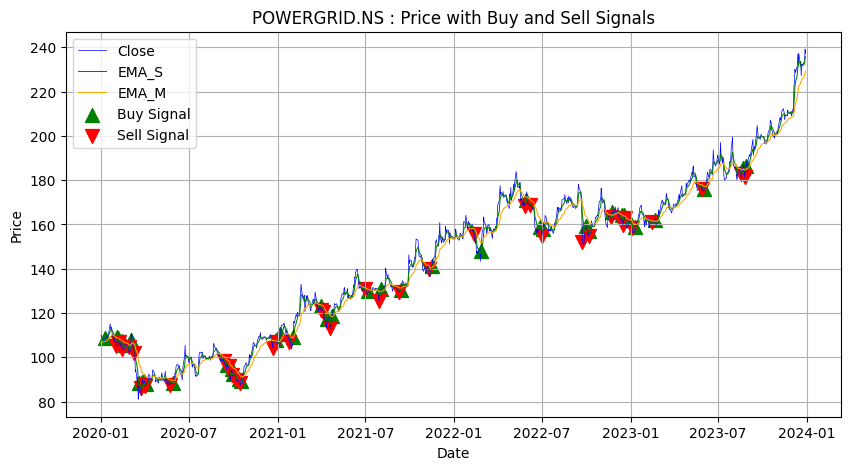

[*********************100%***********************]  1 of 1 completed



Order book for RELIANCE.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  71 Shares are bought at ₹1393.99169921875 on 2020-01-07 00:00:00
SELL:  71 Shares are sold at ₹1345.669189453125 on 2020-01-28 00:00:00
BUY:  72 Shares are bought at ₹1324.410888671875 on 2020-02-05 00:00:00
SELL:  72 Shares are sold at ₹1312.6160888671875 on 2020-02-10 00:00:00
BUY:  72 Shares are bought at ₹1328.296875 on 2020-02-11 00:00:00
SELL:  72 Shares are sold at ₹1295.0609130859375 on 2020-02-25 00:00:00
BUY:  100 Shares are bought at ₹930.7449951171875 on 2020-03-20 00:00:00
SELL:  100 Shares are sold at ₹808.3158569335938 on 2020-03-23 00:00:00
BUY:  81 Shares are bought at ₹989.5365600585938 on 2020-03-25 00:00:00
SELL:  81 Shares are sold at ₹974.8615112304688 on 2020-03-26 00:00:00
BUY:  78 Shares are bought at ₹1018.3380737304688 on 2020-03-31 00:00:00
SELL:  78 Shares are sold at ₹987.8908081054688 on 2020-04-01 00:00:00
BUY:  72 Shares are bought at ₹10

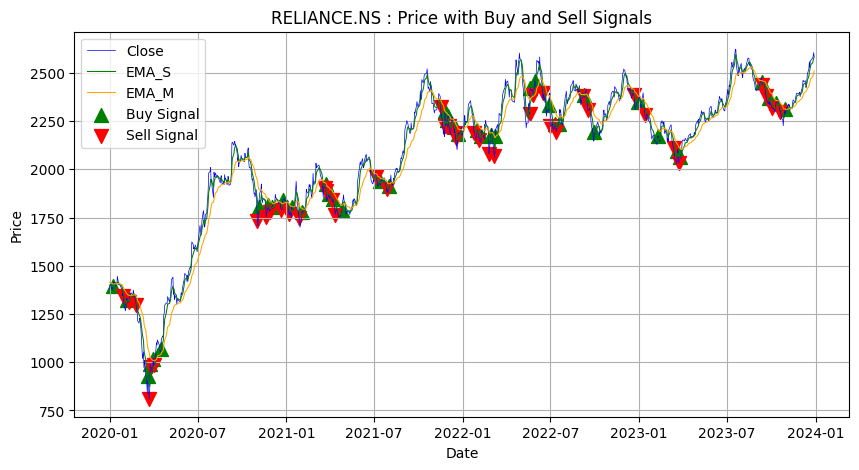

[*********************100%***********************]  1 of 1 completed



Order book for SBILIFE.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  101 Shares are bought at ₹985.9500122070312 on 2020-01-23 00:00:00
SELL:  101 Shares are sold at ₹912.6500244140625 on 2020-02-03 00:00:00
BUY:  97 Shares are bought at ₹947.2999877929688 on 2020-02-07 00:00:00
SELL:  97 Shares are sold at ₹932.8499755859375 on 2020-02-12 00:00:00
BUY:  97 Shares are bought at ₹938.2000122070312 on 2020-02-19 00:00:00
SELL:  97 Shares are sold at ₹916.5999755859375 on 2020-02-24 00:00:00
BUY:  99 Shares are bought at ₹899.8499755859375 on 2020-03-03 00:00:00
SELL:  99 Shares are sold at ₹885.0999755859375 on 2020-03-04 00:00:00
BUY:  141 Shares are bought at ₹618.1500244140625 on 2020-03-26 00:00:00
SELL:  141 Shares are sold at ₹602.8499755859375 on 2020-03-27 00:00:00
BUY:  121 Shares are bought at ₹702.4500122070312 on 2020-04-17 00:00:00
SELL:  121 Shares are sold at ₹671.2999877929688 on 2020-04-21 00:00:00
BUY:  115 Shares are bough

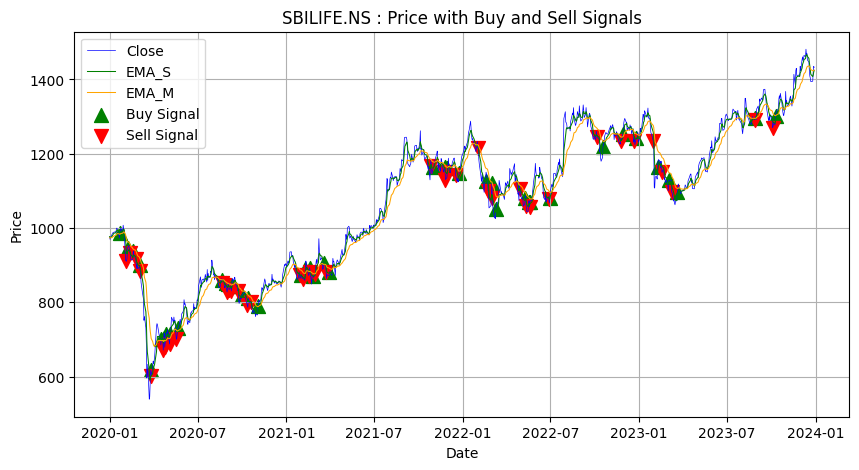

[*********************100%***********************]  1 of 1 completed



Order book for SHRIRAMFIN.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  89 Shares are bought at ₹1117.680419921875 on 2020-01-09 00:00:00
SELL:  89 Shares are sold at ₹1103.357421875 on 2020-01-14 00:00:00
BUY:  91 Shares are bought at ₹1078.8524169921875 on 2020-01-29 00:00:00
SELL:  91 Shares are sold at ₹1016.8836059570312 on 2020-01-30 00:00:00
BUY:  91 Shares are bought at ₹1022.5835571289062 on 2020-02-04 00:00:00
SELL:  91 Shares are sold at ₹1076.9525146484375 on 2020-03-06 00:00:00
BUY:  177 Shares are bought at ₹552.4581909179688 on 2020-03-25 00:00:00
SELL:  177 Shares are sold at ₹507.29693603515625 on 2020-04-03 00:00:00
BUY:  155 Shares are bought at ₹580.1785278320312 on 2020-04-08 00:00:00
SELL:  155 Shares are sold at ₹573.5042114257812 on 2020-04-21 00:00:00
BUY:  141 Shares are bought at ₹627.0936279296875 on 2020-04-23 00:00:00
SELL:  141 Shares are sold at ₹651.062744140625 on 2020-04-24 00:00:00
BUY:  136 Shares are b

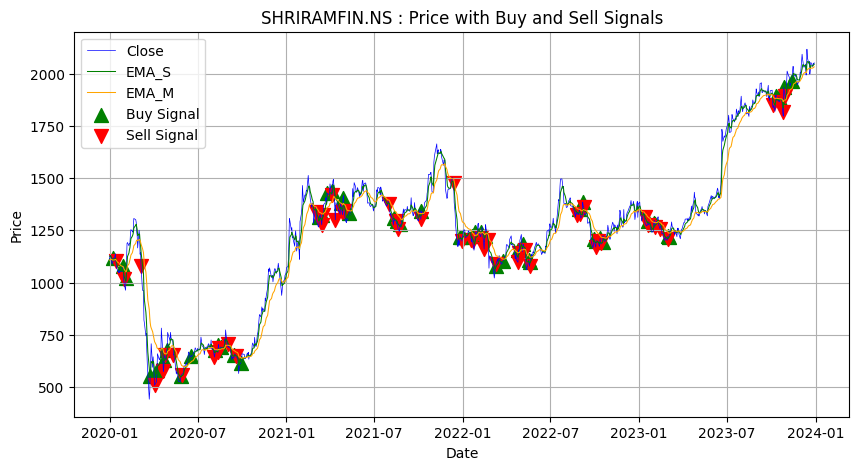

[*********************100%***********************]  1 of 1 completed



Order book for SBIN.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  302 Shares are bought at ₹330.20001220703125 on 2020-01-09 00:00:00
SELL:  302 Shares are sold at ₹324.25 on 2020-01-15 00:00:00
BUY:  303 Shares are bought at ₹323.20001220703125 on 2020-01-23 00:00:00
SELL:  303 Shares are sold at ₹316.20001220703125 on 2020-01-27 00:00:00
BUY:  301 Shares are bought at ₹318.45001220703125 on 2020-01-31 00:00:00
SELL:  301 Shares are sold at ₹298.1000061035156 on 2020-02-03 00:00:00
BUY:  289 Shares are bought at ₹311.0 on 2020-02-05 00:00:00
SELL:  289 Shares are sold at ₹303.0 on 2020-02-28 00:00:00
BUY:  447 Shares are bought at ₹195.9499969482422 on 2020-03-27 00:00:00
SELL:  447 Shares are sold at ₹186.89999389648438 on 2020-03-30 00:00:00
BUY:  424 Shares are bought at ₹196.85000610351562 on 2020-03-31 00:00:00
SELL:  424 Shares are sold at ₹186.5500030517578 on 2020-04-01 00:00:00
BUY:  425 Shares are bought at ₹186.39999389648438 o

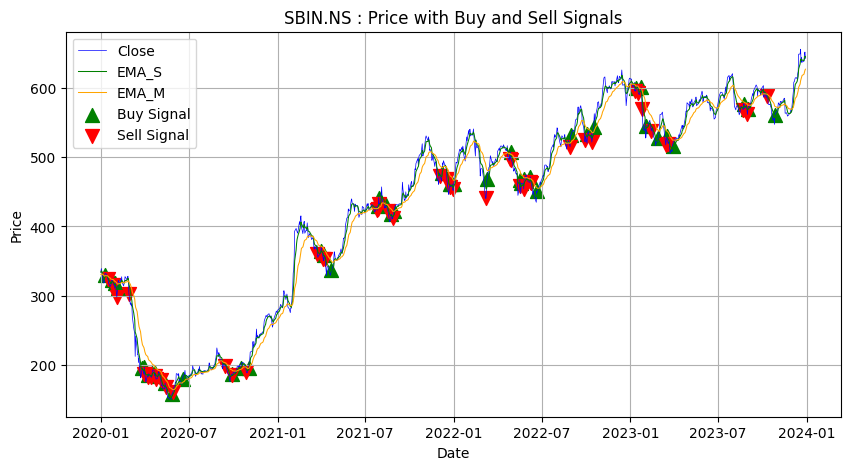

[*********************100%***********************]  1 of 1 completed



Order book for SUNPHARMA.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  225 Shares are bought at ₹443.6000061035156 on 2020-01-10 00:00:00
SELL:  225 Shares are sold at ₹434.29998779296875 on 2020-01-31 00:00:00
BUY:  227 Shares are bought at ₹430.6499938964844 on 2020-02-06 00:00:00
SELL:  227 Shares are sold at ₹420.29998779296875 on 2020-02-10 00:00:00
BUY:  242 Shares are bought at ₹393.54998779296875 on 2020-03-03 00:00:00
SELL:  242 Shares are sold at ₹393.3500061035156 on 2020-03-09 00:00:00
BUY:  248 Shares are bought at ₹384.20001220703125 on 2020-03-13 00:00:00
SELL:  248 Shares are sold at ₹368.54998779296875 on 2020-03-16 00:00:00
BUY:  263 Shares are bought at ₹347.6499938964844 on 2020-03-25 00:00:00
SELL:  263 Shares are sold at ₹338.29998779296875 on 2020-03-26 00:00:00
BUY:  253 Shares are bought at ₹352.29998779296875 on 2020-03-31 00:00:00
SELL:  253 Shares are sold at ₹343.54998779296875 on 2020-04-01 00:00:00
BUY:  185 

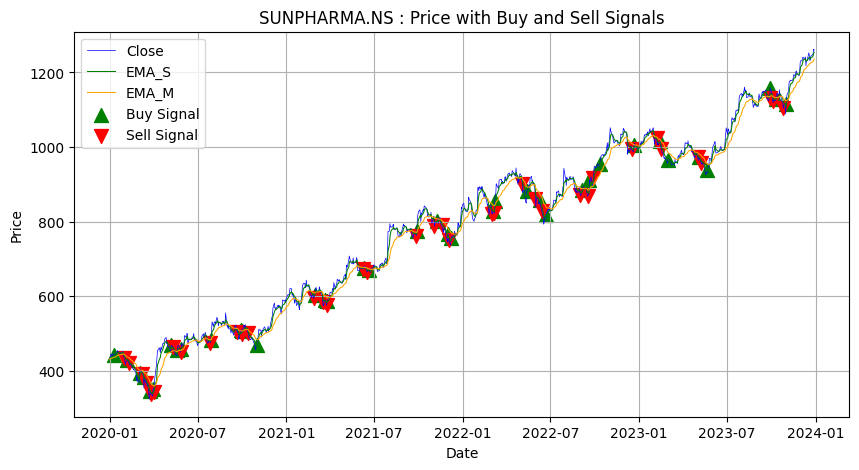

[*********************100%***********************]  1 of 1 completed



Order book for TCS.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  45 Shares are bought at ₹2206.89990234375 on 2020-01-14 00:00:00
SELL:  45 Shares are sold at ₹2170.35009765625 on 2020-01-20 00:00:00
BUY:  44 Shares are bought at ₹2206.89990234375 on 2020-01-22 00:00:00
SELL:  44 Shares are sold at ₹2183.75 on 2020-01-28 00:00:00
BUY:  45 Shares are bought at ₹2146.550048828125 on 2020-02-05 00:00:00
SELL:  45 Shares are sold at ₹2105.5 on 2020-02-27 00:00:00
BUY:  45 Shares are bought at ₹2083.199951171875 on 2020-03-04 00:00:00
SELL:  45 Shares are sold at ₹1972.3499755859375 on 2020-03-09 00:00:00
BUY:  50 Shares are bought at ₹1797.449951171875 on 2020-03-20 00:00:00
SELL:  50 Shares are sold at ₹1669.699951171875 on 2020-03-23 00:00:00
BUY:  48 Shares are bought at ₹1750.300048828125 on 2020-03-25 00:00:00
SELL:  48 Shares are sold at ₹1708.75 on 2020-04-01 00:00:00
BUY:  46 Shares are bought at ₹1775.199951171875 on 2020-04-07 00:00:

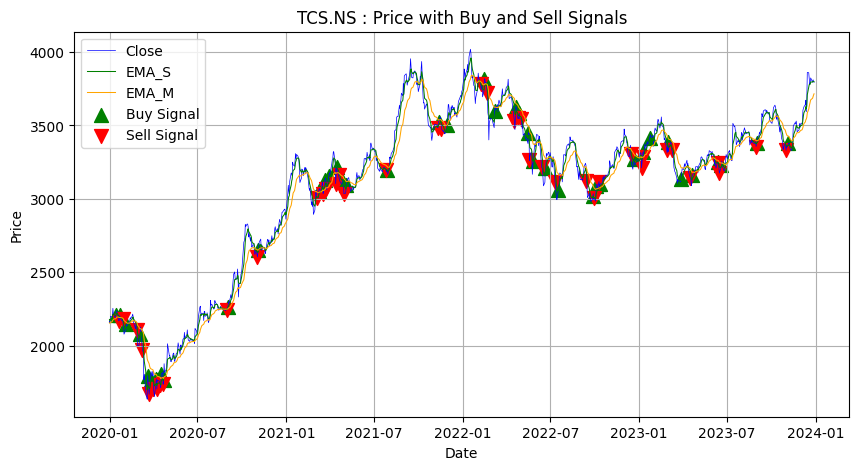

[*********************100%***********************]  1 of 1 completed



Order book for TATACONSUM.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  304 Shares are bought at ₹328.54998779296875 on 2020-01-09 00:00:00
44 6
SELL:  304 Shares are sold at ₹349.20001220703125 on 2020-03-04 00:00:00
BUY:  383 Shares are bought at ₹277.1499938964844 on 2020-03-25 00:00:00
SELL:  383 Shares are sold at ₹279.04998779296875 on 2020-03-26 00:00:00
BUY:  376 Shares are bought at ₹284.54998779296875 on 2020-04-07 00:00:00
SELL:  376 Shares are sold at ₹294.3999938964844 on 2020-04-08 00:00:00
BUY:  335 Shares are bought at ₹330.1499938964844 on 2020-04-22 00:00:00
SELL:  335 Shares are sold at ₹326.1000061035156 on 2020-04-24 00:00:00
BUY:  320 Shares are bought at ₹341.29998779296875 on 2020-05-07 00:00:00
186 84
SELL:  320 Shares are sold at ₹503.25 on 2020-09-29 00:00:00
BUY:  316 Shares are bought at ₹509.1000061035156 on 2020-10-01 00:00:00
SELL:  316 Shares are sold at ₹488.25 on 2020-10-08 00:00:00
BUY:  315 Shares are b

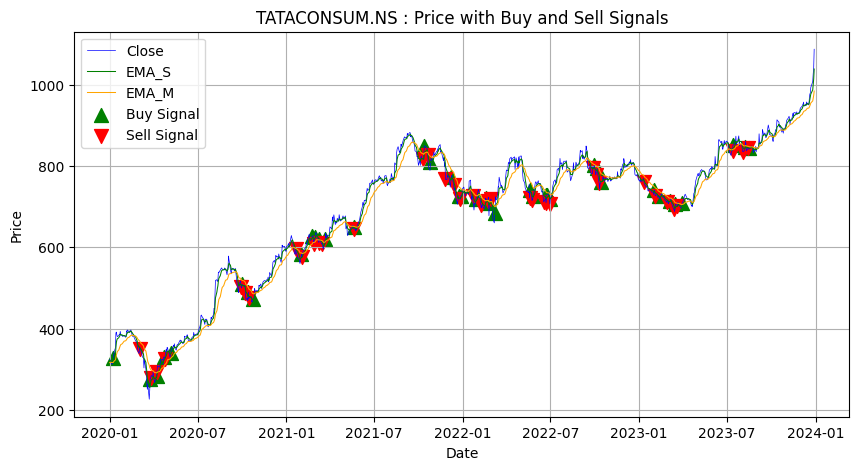

[*********************100%***********************]  1 of 1 completed



Order book for TATAMOTORS.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  520 Shares are bought at ₹192.0 on 2020-01-09 00:00:00
SELL:  520 Shares are sold at ₹185.60000610351562 on 2020-01-22 00:00:00
BUY:  514 Shares are bought at ₹188.0500030517578 on 2020-01-29 00:00:00
SELL:  514 Shares are sold at ₹186.1999969482422 on 2020-01-30 00:00:00
BUY:  520 Shares are bought at ₹183.75 on 2020-02-05 00:00:00
SELL:  520 Shares are sold at ₹178.85000610351562 on 2020-02-06 00:00:00
BUY:  1311 Shares are bought at ₹71.05000305175781 on 2020-03-31 00:00:00
SELL:  1311 Shares are sold at ₹67.94999694824219 on 2020-04-01 00:00:00
BUY:  1194 Shares are bought at ₹74.5999984741211 on 2020-04-09 00:00:00
SELL:  1194 Shares are sold at ₹74.25 on 2020-04-13 00:00:00
BUY:  1168 Shares are bought at ₹75.9000015258789 on 2020-04-22 00:00:00
SELL:  1168 Shares are sold at ₹74.19999694824219 on 2020-04-24 00:00:00
BUY:  1152 Shares are bought at ₹75.25 on 2020

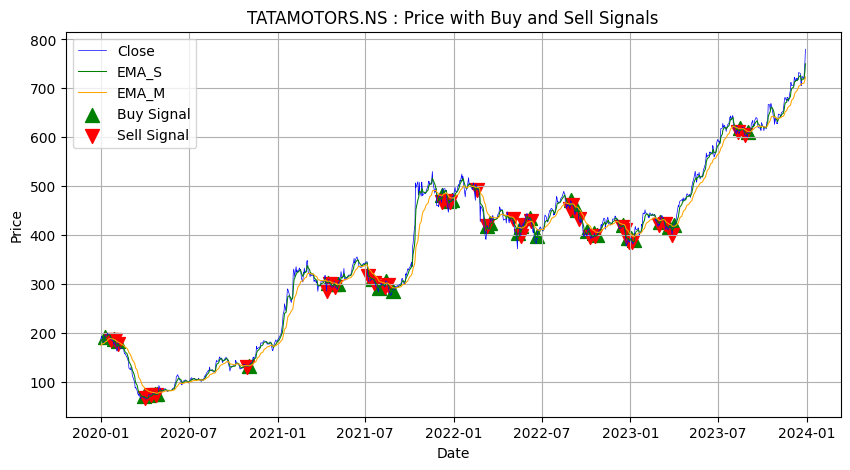

[*********************100%***********************]  1 of 1 completed



Order book for TATASTEEL.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  2100 Shares are bought at ₹47.61000061035156 on 2020-01-07 00:00:00
SELL:  2100 Shares are sold at ₹46.244998931884766 on 2020-01-27 00:00:00
BUY:  2149 Shares are bought at ₹45.189998626708984 on 2020-02-04 00:00:00
SELL:  2149 Shares are sold at ₹44.380001068115234 on 2020-02-10 00:00:00
BUY:  2150 Shares are bought at ₹44.35499954223633 on 2020-02-20 00:00:00
SELL:  2150 Shares are sold at ₹41.54499816894531 on 2020-02-24 00:00:00
BUY:  2734 Shares are bought at ₹32.66999816894531 on 2020-03-13 00:00:00
SELL:  2734 Shares are sold at ₹28.959999084472656 on 2020-03-16 00:00:00
BUY:  2660 Shares are bought at ₹29.774999618530273 on 2020-03-20 00:00:00
SELL:  2660 Shares are sold at ₹27.114999771118164 on 2020-03-23 00:00:00
BUY:  2515 Shares are bought at ₹28.68000030517578 on 2020-03-25 00:00:00
SELL:  2515 Shares are sold at ₹28.44499969482422 on 2020-03-26 00:00:00


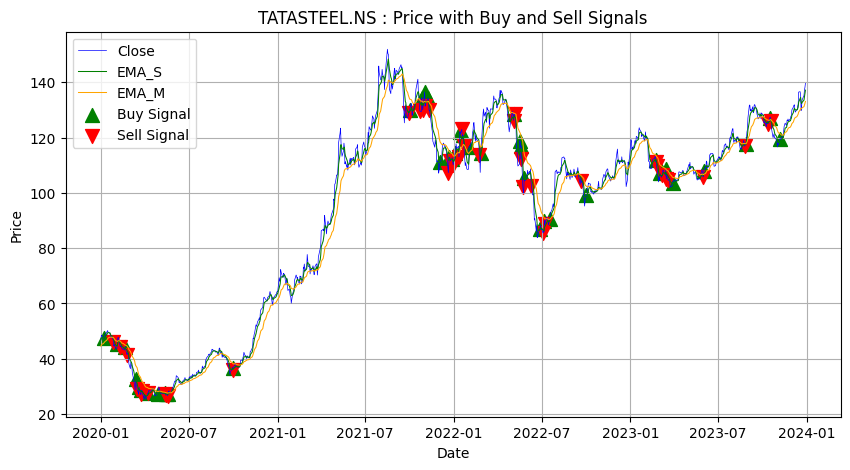

[*********************100%***********************]  1 of 1 completed



Order book for TECHM.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  128 Shares are bought at ₹777.0999755859375 on 2020-01-07 00:00:00
SELL:  128 Shares are sold at ₹744.4000244140625 on 2020-02-28 00:00:00
BUY:  124 Shares are bought at ₹771.2999877929688 on 2020-03-04 00:00:00
SELL:  124 Shares are sold at ₹756.0999755859375 on 2020-03-05 00:00:00
BUY:  178 Shares are bought at ₹526.7999877929688 on 2020-03-30 00:00:00
SELL:  178 Shares are sold at ₹511.20001220703125 on 2020-04-01 00:00:00
BUY:  165 Shares are bought at ₹549.8499755859375 on 2020-04-07 00:00:00
SELL:  165 Shares are sold at ₹558.9000244140625 on 2020-04-08 00:00:00
BUY:  171 Shares are bought at ₹538.6500244140625 on 2020-04-15 00:00:00
SELL:  171 Shares are sold at ₹517.6500244140625 on 2020-04-16 00:00:00
BUY:  169 Shares are bought at ₹524.8499755859375 on 2020-04-20 00:00:00
SELL:  169 Shares are sold at ₹512.9500122070312 on 2020-04-21 00:00:00
BUY:  166 Shares are 

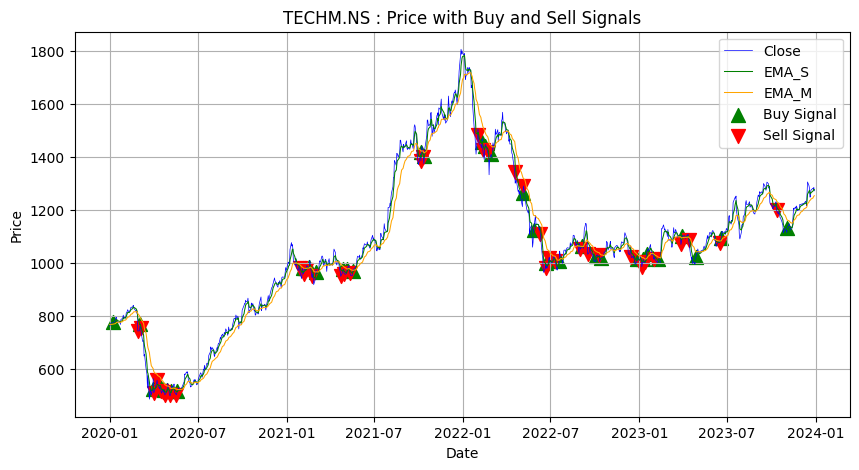

[*********************100%***********************]  1 of 1 completed



Order book for TITAN.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  85 Shares are bought at ₹1163.449951171875 on 2020-01-09 00:00:00
46 6
SELL:  85 Shares are sold at ₹1242.5999755859375 on 2020-03-06 00:00:00
BUY:  121 Shares are bought at ₹880.7999877929688 on 2020-03-25 00:00:00
SELL:  121 Shares are sold at ₹943.6500244140625 on 2020-03-30 00:00:00
BUY:  120 Shares are bought at ₹947.4500122070312 on 2020-04-07 00:00:00
SELL:  120 Shares are sold at ₹913.4500122070312 on 2020-04-08 00:00:00
BUY:  108 Shares are bought at ₹1013.8499755859375 on 2020-04-09 00:00:00
SELL:  108 Shares are sold at ₹966.8499755859375 on 2020-04-13 00:00:00
BUY:  106 Shares are bought at ₹985.25 on 2020-04-16 00:00:00
SELL:  106 Shares are sold at ₹975.5 on 2020-04-17 00:00:00
BUY:  111 Shares are bought at ₹932.8499755859375 on 2020-04-28 00:00:00
SELL:  111 Shares are sold at ₹891.8499755859375 on 2020-05-04 00:00:00
BUY:  115 Shares are bought at ₹860.4500

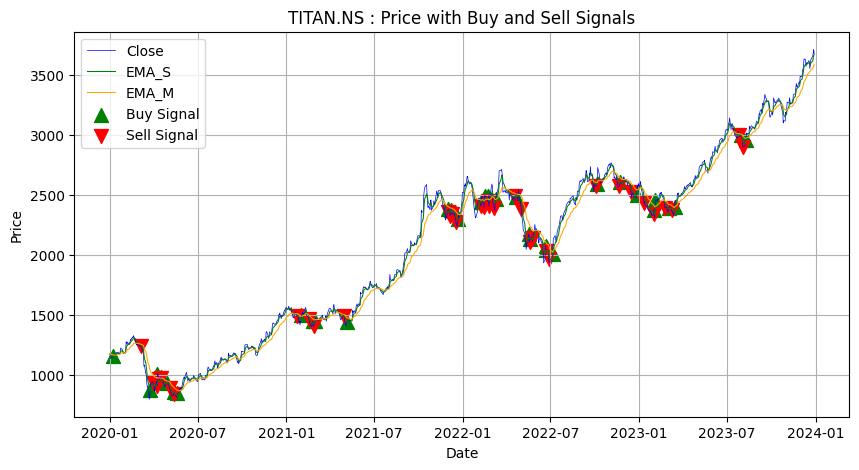

[*********************100%***********************]  1 of 1 completed



Order book for TRENT.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  182 Shares are bought at ₹547.4500122070312 on 2020-01-09 00:00:00
SELL:  182 Shares are sold at ₹600.4500122070312 on 2020-03-13 00:00:00
BUY:  221 Shares are bought at ₹495.75 on 2020-03-26 00:00:00
SELL:  221 Shares are sold at ₹483.29998779296875 on 2020-03-27 00:00:00
BUY:  220 Shares are bought at ₹484.3500061035156 on 2020-03-31 00:00:00
SELL:  220 Shares are sold at ₹465.70001220703125 on 2020-04-01 00:00:00
BUY:  222 Shares are bought at ₹462.6000061035156 on 2020-04-08 00:00:00
SELL:  222 Shares are sold at ₹453.8500061035156 on 2020-04-13 00:00:00
BUY:  219 Shares are bought at ₹460.3500061035156 on 2020-04-16 00:00:00
SELL:  219 Shares are sold at ₹450.54998779296875 on 2020-05-11 00:00:00
BUY:  218 Shares are bought at ₹451.79998779296875 on 2020-05-21 00:00:00
SELL:  218 Shares are sold at ₹442.45001220703125 on 2020-05-22 00:00:00
BUY:  183 Shares are bought 

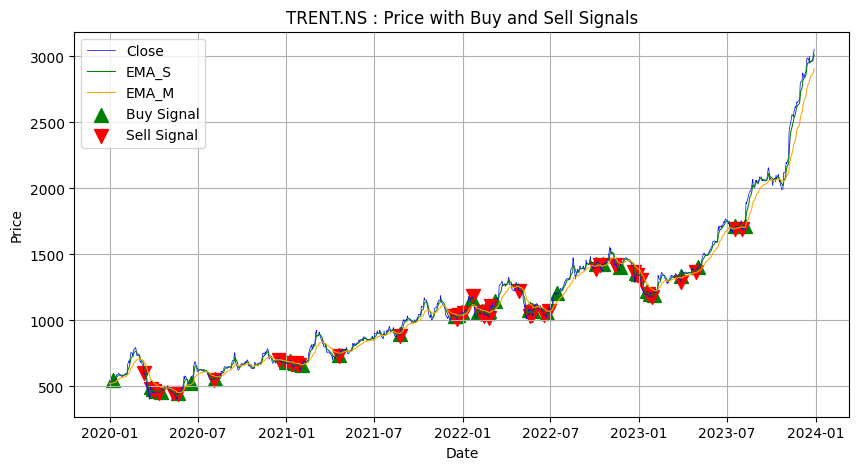

[*********************100%***********************]  1 of 1 completed



Order book for ULTRACEMCO.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  22 Shares are bought at ₹4474.25 on 2020-02-04 00:00:00
SELL:  22 Shares are sold at ₹4475.7001953125 on 2020-02-18 00:00:00
BUY:  23 Shares are bought at ₹4299.89990234375 on 2020-03-03 00:00:00
SELL:  23 Shares are sold at ₹4172.7998046875 on 2020-03-04 00:00:00
BUY:  27 Shares are bought at ₹3573.85009765625 on 2020-03-20 00:00:00
SELL:  27 Shares are sold at ₹3054.85009765625 on 2020-03-23 00:00:00
BUY:  25 Shares are bought at ₹3228.60009765625 on 2020-03-25 00:00:00
SELL:  25 Shares are sold at ₹3229.14990234375 on 2020-03-26 00:00:00
BUY:  25 Shares are bought at ₹3244.85009765625 on 2020-03-31 00:00:00
SELL:  25 Shares are sold at ₹3140.64990234375 on 2020-04-01 00:00:00
BUY:  24 Shares are bought at ₹3279.5 on 2020-04-07 00:00:00
SELL:  24 Shares are sold at ₹3256.449951171875 on 2020-04-08 00:00:00
BUY:  23 Shares are bought at ₹3394.0 on 2020-04-28 00:00:00


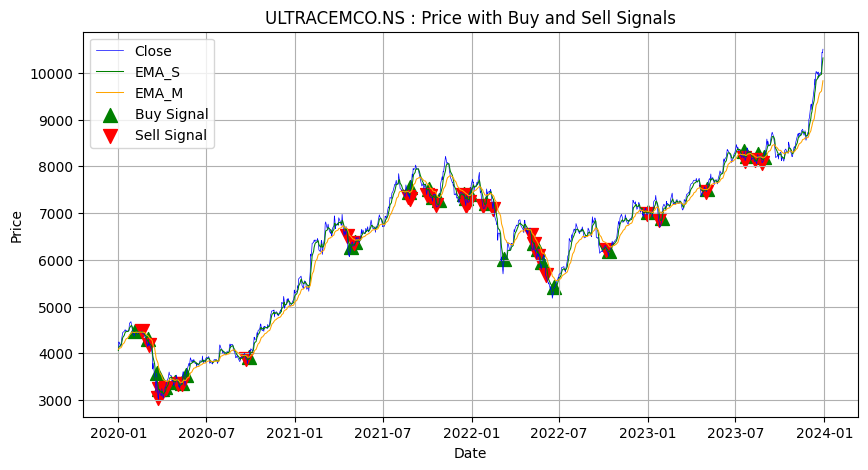

[*********************100%***********************]  1 of 1 completed



Order book for WIPRO.NS between 2020-01-01 and 2023-12-31
------------------------------------------------
BUY:  392 Shares are bought at ₹254.8000030517578 on 2020-01-13 00:00:00
SELL:  392 Shares are sold at ₹248.25 on 2020-01-15 00:00:00
BUY:  391 Shares are bought at ₹248.6999969482422 on 2020-01-23 00:00:00
SELL:  391 Shares are sold at ₹244.0500030517578 on 2020-01-28 00:00:00
BUY:  387 Shares are bought at ₹246.75 on 2020-01-29 00:00:00
SELL:  387 Shares are sold at ₹240.6999969482422 on 2020-01-30 00:00:00
BUY:  385 Shares are bought at ₹242.25 on 2020-02-05 00:00:00
SELL:  385 Shares are sold at ₹231.60000610351562 on 2020-02-27 00:00:00
BUY:  389 Shares are bought at ₹228.85000610351562 on 2020-03-04 00:00:00
SELL:  389 Shares are sold at ₹223.5500030517578 on 2020-03-06 00:00:00
BUY:  486 Shares are bought at ₹179.1999969482422 on 2020-03-20 00:00:00
SELL:  486 Shares are sold at ₹170.14999389648438 on 2020-03-23 00:00:00
BUY:  469 Shares are bought at ₹176.35000610351562 o

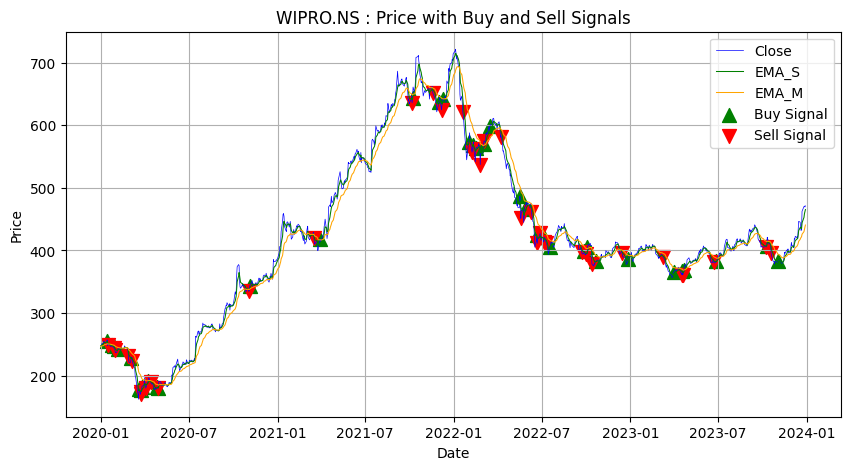

In [8]:
""" Main Execution block
"""

""" Followig parameters can be modified as per requirement:
    1. Wiki source for ticker list
    2. Period of historical price extract
    3. Initial investment amount
    4. Stop loss percentage
    5. Start and End dates
"""

# url for NIFTY50 stocks
url = 'https://en.wikipedia.org/wiki/NIFTY_50'
period = '5y'
investment = 100000
stop_loss_pct = 0.02
duration = 25
start = '2020-01-01'
end = '2023-12-31'

tickers = get_ticker_list(url)
#ticker = "WIPRO.NS"
return_data = []

for ticker in tickers:
    hist_price = extract_hist_price(ticker, period)
    if len(hist_price) is not 0:
       hist_price = add_ema_indicators(hist_price, 5, 20, 50)
       data = hist_price.loc[(hist_price.index >= start) & (hist_price.index <= end)]
       calculate_return(data, ticker, start, end, investment, stop_loss_pct, duration)

In [9]:
header = ['Ticker', 'Earning - Strategy', 'ROI - Strategy', 'Earning - Buy/ Hold', 'ROI - Buy/ Hold']
df_return = pd.DataFrame(return_data, columns=header)
#df_return

In [10]:
round(sum(df_return['Earning - Strategy']), 2)

9225771.78

In [11]:
round(sum(df_return['Earning - Strategy']) * 100/(investment * len(df_return)), 2)

184.52

In [12]:
round(sum(df_return['Earning - Buy/ Hold']), 2)

7534387.44

In [13]:
round(sum(df_return['Earning - Buy/ Hold']) * 100/(investment * len(df_return)), 2)

150.69

In [14]:
len(df_return)

50